In [ ]:
!pip install pandas
!pip install uproot
!pip install numpy
!pip install sys
!pip install matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.8/350.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.9/787.9 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.9/707.9 kB 48.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


In [ ]:

import uproot
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [ ]:
!pip install awkward-pandas


In [ ]:
#!pip install drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def concatenate_trees(directory):
    tree_dict = {}  # Dictionary to store DataFrames for each tree type across all files

    # List all ROOT files in the specified directory
    filenames = glob.glob(f'{directory}/*.root')

    # Collect DataFrames for each tree from each file
    for filename in filenames:
        with uproot.open(filename) as file:
            for tree_name in file.keys():
                clean_tree_name = tree_name.decode('utf-8').rstrip(';1')
                if clean_tree_name not in tree_dict:
                    tree_dict[clean_tree_name] = []
                tree = file[clean_tree_name]
                df = tree_to_pandas(tree)
                tree_dict[clean_tree_name].append(df)

    all_dataframes = {}
    all_dicts = {}

    # Concatenate DataFrames for each tree type and process them
    for tree_name, dfs in tree_dict.items():
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"\nProcessing combined tree: {tree_name}")
        print("Before padding:")
        print(combined_df.head())
        print(f"Shape {combined_df.shape}")

        padded_df, event_data_dict = pad_dataframe(combined_df)
        print("After padding:")
        print(padded_df.head())

        all_dataframes[tree_name] = padded_df
        all_dicts[tree_name] = event_data_dict

    return all_dataframes, all_dicts


In [ ]:


import glob

def test2(directory):
    all_dataframes = {}  # Dictionary to hold combined DataFrames for each tree type
    all_dicts = {}       # Dictionary to hold additional data like event_data_dict for each tree type

    filenames = glob.glob(f'{directory}/*.root')  # Gets all .root files in the directory
    trees_collected = {}  # This will hold lists of DataFrames to be concatenated

    # First, collect all DataFrames corresponding to each tree across all files
    for filename in filenames:
        with uproot.open(filename) as file:
            for tree_name in file.keys():
                tree_name_cleaned = tree_name.decode("utf-8").strip(';1') if isinstance(tree_name, bytes) else tree_name
                if tree_name_cleaned not in trees_collected:
                    trees_collected[tree_name_cleaned] = []
                tree = file[tree_name_cleaned]
                df = tree_to_pandas(tree)
                trees_collected[tree_name_cleaned].append(df)

    # Now, concatenate DataFrames for each tree type and process them
    for tree_name, dfs in trees_collected.items():
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"Processing combined tree: {tree_name}")
        print("Before padding:")
        print(combined_df.head())
        print(f"shape {combined_df.shape}")

        padded_df, event_data_dict = pad_dataframe(combined_df)
        print("After padding:")
        print(padded_df.head())

        all_dataframes[tree_name] = padded_df
        all_dicts[tree_name] = event_data_dict

    return all_dataframes, all_dicts


def test22(directory):
    all_dataframes = []  # List to hold all DataFrames
    all_dicts = {}  # Dictionary to hold all dicts

    filenames = glob.glob(f'{directory}/*.root')  # Gets all .root files in the directory
    for filename in filenames:
        with uproot.open(filename) as file:
            for tree_name in file.keys():
                tree_name = tree_name.decode("utf-8").strip(';1') if isinstance(tree_name, bytes) else tree_name
                print(f"\nProcessing Tree: {tree_name}")
                tree = file[tree_name]
                df = tree_to_pandas(tree)

                #print("Before padding:")
                #print(df.head())
                #print(f"shape {df.shape}")

                padded_df, event_data_dict = pad_dataframe(df)
                #print("After padding:")
                print(padded_df.head())

                for col in df.columns:
                    nparr = np.asarray(df[col]).reshape(-1,1)
                    #print(f"name {col} shape {df[col].shape}")
                    #print(f"name {col} shape np {nparr.shape}")

                # try:
                #     print("mcTruth_pdgCodeClu")
                #     print(df["mcTruth_pdgCodeClu"])
                #     print(df["mcTruth_pdgCodeClu"].dtype)
                # except KeyError:
                #     print("KeyError in accessing mcTruth_pdgCodeClu")

                all_dataframes.append(padded_df)
                all_dicts[tree_name] = event_data_dict

    combined_df = pd.concat(all_dataframes, ignore_index=True)
    return combined_df, all_dicts



In [ ]:


import matplotlib
#matplotlib.use('TkAgg')  # Use in standalone scripts to specify an interactive backend
def plot_numerical_histogram(df, column_name, output_file, **kwargs):
    """
    Plots a numerical histogram for a specified column in a DataFrame and saves it as a file.

    Args:
    df (pandas.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to plot.
    output_file (str): File path where the plot will be saved.
    bins (int): Number of bins to use in the histogram.
    """
    if column_name in df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(df[column_name].dropna(), alpha=0.75, color='blue', **kwargs)  # Drop NaN values
        plt.title(f'Numerical Histogram of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()  # Close the plot figure to free up memory

        plt.savefig(output_file)  # Save the figure to a file
        plt.close()  # Close the plot figure to free up memory
        print(f"Plot saved to {output_file}")
    else:
        print(f"Column {column_name} does not exist in the DataFrame.")



def print_column_shapes(df):
    # Iterate through each column in the DataFrame
    for column in df.columns:
        # Count the non-null entries in each column
        non_null_count = df[column].notna().sum()
        print(f"Column: {column}, Non-Null Count: {non_null_count} / {df[column].shape}")


def tree_to_pandas(tree):
    df = tree.arrays(library="pd")
    print("DataFrame shape:", df.shape)  # This line prints the shape of the DataFrame
    print(f"Number of entries in the tree: {tree.num_entries}")
    return df

def plot_histogram(df, column_name, output_file):
    """
    Plots a categorical histogram for specified PDG codes in a DataFrame column,
    treating all values as their absolute values, and saves the plot to a file.

    Args:
    df (pandas.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to plot.
    output_file (str): Filename to save the plot.
    """
    if column_name in df.columns:
        # Define PDG codes of interest and take the absolute values from the column
        pdg_codes_of_interest = [11, 13, 211, 321, 2212, 22]
        # Filter and take absolute values
        filtered_series = df[column_name].abs()
        filtered_series = filtered_series[filtered_series.isin(pdg_codes_of_interest)]

        # Convert the series to categorical with the specified categories
        filtered_series = pd.Categorical(filtered_series, categories=pdg_codes_of_interest, ordered=True)

        # Plotting
        plt.figure(figsize=(10, 6))
        pd.Series(filtered_series).value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.75)
        plt.title(f'Categorical Histogram of {column_name}')
        plt.xlabel('Absolute PDG Code')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.xticks(rotation=0)  # Ensure x labels are not rotated and are readable
        plt.show()
        plt.savefig(output_file)
        plt.close()
        print(f"Plot saved to {output_file}")
    else:
        print(f"Column {column_name} does not exist in the DataFrame.")


# Example usage:
# plot_histogram(df, 'mcTruth_pdgCodeClu')


from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_and_stack2(sequences, max_length=None):
	try:
		# Try padding, if max_length is not None, pad or truncate to that length
		padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # Changed dtype to 'floar32'
		#print("padded ok")
	except ValueError:
		# Fallback: manually pad with zeros
		max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
		padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])
		#print("revert to other pad")

	return padded_sequences


def pad_and_stack3(sequences, max_length=None):
		# Check if sequences is a single numpy array and not a list of sequences.
		# If it's a single array, wrap it in a list.
		if isinstance(sequences, np.ndarray) and sequences.ndim == 1:
				sequences = [sequences]  # Wrap the single array in a list to create a list of sequences.

		try:
				# Try padding, if max_length is not None, pad or truncate to that length.
				padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # dtype was corrected to 'float32'.
				#print("padded ok")
		except ValueError as e:
				print(f"pad_and_stack3 : ValueError: {e}")  # Print the error for debugging.
				# Fallback: manually pad with zeros if there's an error.
				max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
				padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])
				#print("reverted to manual padding")

		if padded_sequences.shape[1] == max_length:
				padded_sequences = padded_sequences.transpose()


		return padded_sequences


def pad_dataframe(df):
    df_out = pd.DataFrame()
    max_lengths = {}
    dtype_map = {}


    # First pass to determine max lengths and data types
    for col in df.columns:

        print(f"df[col] shape {df[col].shape}")
        df[col] = df[col].apply(lambda x: np.array(x, dtype=object) if isinstance(x, (list, np.ndarray)) else x)

        lengths = df[col].apply(lambda x: len(x) if isinstance(x, np.ndarray) else 0)
        max_lengths[col] = lengths.max()



        if max_lengths[col] > 0:

            first_element = df.loc[df[col].apply(lambda x: isinstance(x, np.ndarray) and len(x) > 0), col].iloc[0][0]
            dtype_map[col] = type(first_element)
        else:
            dtype_map[col] = df[col].dtype
            print(f"{col} : Target datatype from ROOT datatype {df[col].dtype}")



    col = df.columns[0]
    max_length = max_lengths[col]
    if max_length == 0:
        npz = np.zeros((len(df[col]), 1))
    else :
        npz = np.zeros((len(df[col]), max_length))

    #print(f"npz {npz.shape}")
    np_arrays = {col: np.empty((len(df), max_lengths[col]), dtype=dtype_map[col]) for col in df.columns}

    #df_out = pd.DataFrame({col: [np.zeros_like(npz) for _ in range(len(df))] for col in df.columns})


    dtype_list = [(col, dtype_map[col], (max_lengths[col],)) for col in df.columns]

    event_data_dict = {}  # add CkovHyps here?

    #print(f"max_length {max_length}")
    # Second pass to pad and enforce data type consistency
    for col, max_length in max_lengths.items():
        print(f"col {col}")
        event_data_dict[col] = np.zeros_like(npz)
        data_type = df[col].dtype
        #print(f"max_length {max_length}")

        # q_padded2 = pad_and_stack2(df[col], max_length=max_length)
        # print(f"q_padded2 {q_padded2.shape}")



        # df2 = pad_and_stack2(df[col], max_length=max_length)
        # print(f"df2 {df2.shape}")


        if max_length > 0:

            event_data_dict[col] =  pad_and_stack2(df[col], max_length=max_length)
            #print(f"col {col} event_data_dict[col] { event_data_dict[col].shape}")


            # sequences = df[col].tolist()
            # # Use the custom padding function to pad the sequences
            # padded_sequences = pad_and_stack2(sequences, max_length=max_length)

            # print(f"padded_sequences shape{padded_sequences.shape}")

            # # Assign the padded sequences back to the DataFrame
            # df[col] = padded_sequences#list(padded_sequences)
            # print(f"df[col] {df[col].shape}")

            # npz = np.zeros((len(df[col]), max_length))
            # target_dtype = dtype_map[col]  # Get the mapped data type
            # print(f"df[col] {df[col].shape}")

            # df_out[col] = padded_sequences
            # print(f"df_out[col] {df_out[col].shape}")

            # npz = df[col]

            # print(f"{col} : Target datatype {target_dtype}, from ROOT datatype {data_type}")
            # df[col] = df[col].apply(lambda x: np.pad(x.astype(target_dtype), (0, max_length - len(x)), 'constant') if isinstance(x, np.ndarray) and len(x) > 0 else np.zeros(max_length, dtype=target_dtype))

            # dfc = np.asarray(df[col])
            # print(dfc.shape)
            # print(type(dfc))
            # q_padded2 = pad_and_stack2(df[col], max_length=max_length)


            # print(f"q_padded2 {q_padded2.shape}")

            # print(df[col])
            # print(dfc.shape)

        else :
            #npz = np.zeros((len(df[col]), max_length))
            #df[col] = df[col].astype(dtype_map[col])
            event_data_dict[col] =  (df[col])
            #print(f"df[col] {event_data_dict[col].shape}")


    #print(f"event_data_dict length: {len(event_data_dict)}")

    for key, value in event_data_dict.items():
        print(f"{key}: {value.shape}")
    #print(f"event_data_dict length: {len(event_data_dict)}")


    #print(f"Num keys in event_data_dict {event_data_dict.items()}")

    return df, event_data_dict


def print_array_lengths(df):
    for col in df.columns:
        # Check if the column contains non-scalar data (numpy arrays)
        if isinstance(df[col].iloc[0], np.ndarray):
            lengths = [len(arr) for arr in df[col]]


            if all(length == lengths[0] for length in lengths):
                print("- All lengths are the same.")
            else:
                print("- Lengths vary.")





def test2_file(file_name="data.root"):
    all_dataframes = []  # List to hold all DataFrames
    all_dicts = {}  # List to hold all dicts

    with uproot.open(file_name) as file:
        for tree_name in file.keys():
            tree_name = tree_name.decode("utf-8") if isinstance(tree_name, bytes) else tree_name
            print(f"\nProcessing Tree: {tree_name}")
            tree = file[tree_name]
            df = tree_to_pandas(tree)

            print("Before padding:")
            print(df.head())
            print(f"shape {df.shape}")

            padded_df, event_data_dict = pad_dataframe(df)
            print("After padding:")
            print(padded_df.head())

            #print(f"shape {padded_df.shape}")

            for col in df.columns:
                nparr = np.asarray(df[col]).reshape(-1,1)
                print(f"name {col} shape {df[col].shape}")
                print(f"name {col} shape np {nparr.shape}")


            try:

                print("mcTruth_pdgCodeClu")
                print(df["mcTruth_pdgCodeClu"])

                print(df["mcTruth_pdgCodeClu"].dtype)

            except:
                print()

            all_dataframes.append(padded_df)

            all_dicts[tree_name] = event_data_dict

            try:
                print("Original data type:", df['mcTruth_pdgCodeTrack;'].dtype)
            except:
                print("wrong tree")


    combined_df = pd.concat(all_dataframes, ignore_index=True)
    return combined_df, all_dicts


def calculate_distances(df):
    x_mip = df['TrackAttributes_xMipThisTrack']
    x_pc = df['TrackAttributes_xPCThisTrack']
    y_mip = df['TrackAttributes_yMipThisTrack']
    y_pc = df['TrackAttributes_yPCThisTrack']

    # Calculate the Euclidean distance using numpy for vectorized operations
    dist = np.sqrt((x_mip - x_pc)**2 + (y_mip - y_pc)**2)
    return dist


def plot_distance_histogram(df, output_file, bins=30, range = (-12, 12), title = "placeholder"):
    """
    Calculates the Euclidean distance between mip and PC points and plots a histogram.

    Args:
    df (pandas.DataFrame): DataFrame containing the mip and PC coordinates.
    output_file (str): Path to save the histogram image.
    bins (int): Number of bins in the histogram.
    """
    # Calculate distances
    df['TrackAttributes_mipPcDistThisTrack'] = calculate_distances(df)
    mask = (df['TrackAttributes_mipPcDistThisTrack'] >= range[0]) & (df['TrackAttributes_mipPcDistThisTrack'] <= range[1])
    # Plotting the histogram of distances
    plt.figure(figsize=(10, 6))
    dist_values = df.loc[mask, 'TrackAttributes_mipPcDistThisTrack']

    mean_dist = np.mean(dist_values)
    std_dist = np.std(dist_values)


    plt.hist(df['TrackAttributes_mipPcDistThisTrack'].dropna(), bins=bins, alpha=0.75, color='blue', range = (0, range[1]))
    plt.title(f'{title} Distance (mip-PC)')
    plt.xlabel('Distance [cm]')
    plt.ylabel('Frequency')
    plt.annotate(f'Mean (µ): {mean_dist:.2f}\nStd Dev (σ): {std_dist:.2f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)
    plt.grid(True)
    plt.show()
    plt.savefig(output_file)

    plt.close()

    print(f"Plot saved to {output_file}")

# Example usage:
# plot_distance_histogram(combined_df, 'mip_pc_distance_histogram.png')

def add_component_distances(df):

    df['TrackAttributes_xMipPcDistThisTrack'] = df['TrackAttributes_xMipThisTrack'] - df['TrackAttributes_xPCThisTrack']
    df['TrackAttributes_yMipPcDistThisTrack'] = df['TrackAttributes_yMipThisTrack'] - df['TrackAttributes_yPCThisTrack']
    return df



def plot_component_distance_histograms(df, output_file_prefix, bins=30, range = (-12, 12), title = "placeholder"):
    """
    Plots separate histograms for the x and y distances between mip and PC.

    Args:
    df (pandas.DataFrame): DataFrame containing the calculated distances.
    output_file_prefix (str): Base path to save histogram images, appended with '_x' and '_y' for respective histograms.
    bins (int): Number of bins in the histogram.
    """
    # Check if distance calculations are done
    if 'TrackAttributes_xMipPcDistThisTrack' not in df or 'TrackAttributes_yMipPcDistThisTrack' not in df:
        df = add_component_distances(df)

    mask_x = (df['TrackAttributes_xMipPcDistThisTrack'] >=  range[0]) & (df['TrackAttributes_xMipPcDistThisTrack'] <=  range[1])
    mask_y = (df['TrackAttributes_yMipPcDistThisTrack'] >=  range[0]) & (df['TrackAttributes_yMipPcDistThisTrack'] <=  range[1])

    x_values = df.loc[mask_x, 'TrackAttributes_xMipPcDistThisTrack']
    y_values = df.loc[mask_y, 'TrackAttributes_yMipPcDistThisTrack']


    mean_x = np.mean(x_values)
    std_x = np.std(x_values)

    mean_y = np.mean(y_values)
    std_y = np.std(y_values)


    # Plotting the histogram of x distances
    plt.figure(figsize=(10, 6))
    plt.hist(x_values, bins=bins, alpha=0.75, color='blue', label='x Distance (mip-PC)', range=range)
    plt.title(f'{title} x Component Distances (mip-PC)')
    plt.xlabel('x Distance')
    plt.ylabel('Frequency')
    plt.annotate(f'Mean (µ): {mean_x:.2f}\nStd Dev (σ): {std_x:.2f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)
    plt.grid(True)
    plt.savefig(f"{output_file_prefix}_x.png")
    plt.show()
    plt.close()

    # Plotting the histogram of y distances
    plt.figure(figsize=(10, 6))
    plt.hist(y_values, bins=bins, alpha=0.75, color='red', label='y Distance (mip-PC)', range=range)
    plt.title(f'{title} y Component Distances (mip-PC)')
    plt.xlabel('y Distance')
    plt.ylabel('Frequency')
    plt.annotate(f'Mean (µ): {mean_y:.2f}\nStd Dev (σ): {std_y:.2f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)
    plt.grid(True)
    plt.savefig(f"{output_file_prefix}_y.png")
    plt.show()

    plt.close()
    print(f"Plots saved to {output_file_prefix}_x.png and {output_file_prefix}_y.png")
import matplotlib.pyplot as plt

def plot_ckovRecon_by_pdg(df, pdg_codes, ckov_col='TrackAttributes_ckovReconThisTrack', pdg_col='mcTruth_pdgCodeTrack;'):
    """
    Plots histograms of reconstructed Cherenkov values split by specified PDG codes.

    Args:
    df (pandas.DataFrame): DataFrame containing the data.
    pdg_codes (list of int): List of PDG codes to plot.
    ckov_col (str): Column name for Cherenkov values.
    pdg_col (str): Column name for PDG codes.
    """
    plt.figure(figsize=(12, 8))


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))  # Set up a figure with two subplots side by side

    # Loop through the specified PDG codes and plot a histogram for each
    for pdg in pdg_codes:

        pdg_codes_of_interest = [pdg, 1111]
        # Filter and take absolute values
        filtered_series = df[pdg_col].abs()
        filtered_series = filtered_series[filtered_series.isin(pdg_codes_of_interest)]

        print(filtered_series)
        print(type(filtered_series))

        #filtered_series = pd.Categorical(filtered_series, categories=pdg_codes_of_interest, ordered=True)

        # Filter data for the current PDG code
        mask = df[pdg_col].abs() == pdg  # Use absolute value to ignore charge
        subset = df.loc[mask, ckov_col].dropna()  # Drop NaN values in the Cherenkov column

        pdg_code = df["mcTruth_pdgCodeTrack;"]


        ckov = df["TrackAttributes_ckovReconThisTrack"]
        ckov_mask = ckov >  0


        ckovmh = df["TrackAttributes_ckovReconMassHypThisTrack"]
        ckovmh_mask = ckovmh >  0

        pdg_code_of_interest = int(pdg)

        pdg_mask = df[pdg_col].abs() == pdg_code_of_interest
        combined_mask = pdg_mask & ckov_mask

        # Apply combined mask to DataFrame
        filtered_df = df.loc[combined_mask]
        pdg_mask = pdg_code == int(pdg)
        print(f"Values of TrackAttributes_ckovReconThisTrack for PDG {pdg_code_of_interest}:")
        print(filtered_df['TrackAttributes_ckovReconThisTrack'])


        print(f"filtered_df shape {pdg_mask.shape}")
        print(f"Number of entries with PDG {pdg_code_of_interest}: {pdg_mask.sum()}")  # .sum() on a boolean mask will count True values

        print(f"Number of entries wckov_mask  {ckov_mask.sum()}")  # .sum() on a boolean mask will count True values
        ckovpdg_mask = ckov_mask & pdg_mask
        print(f"Number of entries ckovpdg_mask  {ckovpdg_mask.sum()}")  # .sum() on a boolean mask will count True values

        print(type(pdg_code))

        print("First 10 PDG codes where Cherenkov mask is True:")
        print(filtered_df[pdg_col].head(10))
        print(f"ckov shape {ckov.shape}")
        print(f"ckov_mask {ckov[ckov_mask]}")



        print(f"pdg_mask {ckov[pdg_mask]}")
        print(f"ckov {ckov[ckov_mask & pdg_mask]}")

        print(f"For pdg {pdg} : mask {subset}")


        print(f"For pdg {pdg} : mask {ckov}")
        #ckov_mask = ckov >  0

        # Plot histogram
        plt.hist(ckov[ckov_mask], bins=50, alpha=0.75, range =(0.5, 0.8), label=f'PDG {pdg}')
        plt.title('Histogram of Reconstructed Cherenkov Values by PDG Code')
        plt.savefig("pdgCkov.png")

        plt.hist(ckovmh[ckovmh_mask], bins=50, alpha=0.75, range =(0.5, 0.8), label=f'PDG {pdg}')
        plt.title('Histogram of Reconstructed Cherenkov Values by mh')
        plt.savefig("mh.png")



        axs[0].hist(ckov[ckov_mask], bins=50, alpha=0.75, range =(0.5, 0.8), label=f'PDG {pdg} in {ckov_col}')
        axs[0].set_title(f'Histogram of {ckov_col} by PDG Code')
        axs[0].set_xlabel('Reconstructed Cherenkov Value')
        axs[0].set_ylabel('Frequency')
        axs[0].legend()
        axs[0].grid(True)

        axs[1].hist(ckovmh[ckovmh_mask], bins=50, alpha=0.75, range =(0.5, 0.8), label=f'PDG {pdg} in {ckov_col}')
        axs[1].set_title(f'Histogram of {ckov_col} by PDG Code')
        axs[1].set_xlabel('Reconstructed Cherenkov Value')
        axs[1].set_ylabel('Frequency')
        axs[1].legend()
        axs[1].grid(True)


    fig.savefig("pdgCkovSideBySide.png")  # Uncomment to save the figure to a file

    plt.title('Histogram of Reconstructed Cherenkov Values by PDG Code')
    plt.xlabel('Reconstructed Cherenkov Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.savefig("pdgCkov.png")
    plt.close()


# Example usage:
# plot_ckovRecon_by_pdg(df=combined_df, pdg_codes=[211, 321, 2212])


## Read files

In [ ]:

# file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/LeadLead/alicemlPb.root'

# file_name3 = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/lococc/mergedBothPc.root'
# combined_df3, all_dicts3 = test2_file(file_name3)

# file_name2 = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/lococc/mergedBothMip.root'
# combined_df2, all_dicts2 = test2_file(file_name2)




file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/LeadLead/alicemlPb20Sigma.root'
file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/DellPionKaon/mergedP_3_K_1.root'
file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/LeadLead/alicemlPb20Sigma.root'
file_name = '/content/drive/MyDrive/ColabNotebooks/root2Pandas/LeadLead/alicemlLead40full.root'

combined_df, all_dicts = test2_file(file_name)





Processing Tree: SumProballTracks;1
DataFrame shape: (3871, 1)
Number of entries in the tree: 3871
Before padding:
                             sumProbabilityAllTracks
0  [0.0, 0.0, 0.5817973613739014, 0.9555784463882...
1  [0.0, 0.0, 0.5817973613739014, 0.9555784463882...
2  [0.0, 0.3176525831222534, 0.42477652430534363,...
3  [0.0, 0.0, 0.0, 0.42250603437423706, 0.0, 0.0,...
4  [0.0, 0.0, 0.0, 0.42250603437423706, 0.0, 0.0,...
shape (3871, 1)
df[col] shape (3871,)
col sumProbabilityAllTracks
sumProbabilityAllTracks: (3871, 683)
After padding:
                             sumProbabilityAllTracks
0  [0.0, 0.0, 0.5817973613739014, 0.9555784463882...
1  [0.0, 0.0, 0.5817973613739014, 0.9555784463882...
2  [0.0, 0.3176525831222534, 0.42477652430534363,...
3  [0.0, 0.0, 0.0, 0.42250603437423706, 0.0, 0.0,...
4  [0.0, 0.0, 0.0, 0.42250603437423706, 0.0, 0.0,...
name sumProbabilityAllTracks shape (3871,)
name sumProbabilityAllTracks shape np (3871, 1)
mcTruth_pdgCodeClu

wrong tree

Process

In [ ]:

file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/LeadLead/alicemlPb.root'
file_name = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/DellPionKaon/mergedP_3_K_06.root'
file_name = '/content/drive/MyDrive/ColabNotebooks/root2Pandas/LeadLead/alicemlLead40full.root'

combined_df, all_dicts = test2_file(file_name)


Processing Tree: SumProballTracks;1
DataFrame shape: (4580, 1)
Number of entries in the tree: 4580
Before padding:
                             sumProbabilityAllTracks
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  [0.0, 0.0, 1.7504897117614746, 0.5715086460113...
2  [0.0, 0.9675161838531494, 0.250357449054718, 0...
3  [0.0, 0.5558146834373474, 0.0, 0.0, 0.58450400...
4  [0.0, 0.9232780337333679, 1.664090871810913, 0...
shape (4580, 1)
df[col] shape (4580,)
col sumProbabilityAllTracks
sumProbabilityAllTracks: (4580, 120)
After padding:
                             sumProbabilityAllTracks
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  [0.0, 0.0, 1.7504897117614746, 0.5715086460113...
2  [0.0, 0.9675161838531494, 0.250357449054718, 0...
3  [0.0, 0.5558146834373474, 0.0, 0.0, 0.58450400...
4  [0.0, 0.9232780337333679, 1.664090871810913, 0...
name sumProbabilityAllTracks shape (4580,)
name sumProbabilityAllTracks shape np (4580, 1)
mcTruth_pdgCodeClu

wrong tree

Process

In [ ]:

pdg = combined_df['mcTruth_pdgCodeTrack;']
momentum = combined_df['TrackAttributes_momentumThisTrack']

ckov_th_pion = combined_df[combined_df["TrackAttributes_ckovThPionThisTrack"]]
ckov_th_kaon = combined_df[combined_df["TrackAttributes_ckovThKaonThisTrack"]]
ckov_th_proton = combined_df[combined_df["TrackAttributes_ckovThProtonThisTrack"]]

ckov_recon = combined_df[combined_df["TrackAttributes_ckovReconThisTrack"]]
ckov_recon_mh = combined_df[combined_df["TrackAttributes_ckovReconMassHypThisTrack"]]




# name TrackAttributes_ckovThKaonThisTrack shape (2483,)
# name TrackAttributes_ckovThKaonThisTrack shape np (2483, 1)
# name TrackAttributes_ckovThProtonThisTrack shape (2483,)
# name TrackAttributes_ckovThProtonThisTrack shape np (2483, 1)
# name TrackAttributes_refIndexThisTrack shape (2483,)
# name TrackAttributes_refIndexThisTrack shape np (2483, 1)
# name TrackAttributes_ckovReconThisTrack shape (2483,)
# name TrackAttributes_ckovReconThisTrack shape np (2483, 1)
# name TrackAttributes_ckovReconMassHypThisTrack shape (2483,)
# name TrackAttributes_ckovReconMassHypThisTrack shape np (2483, 1)




print("TrackAttributes_xRadThisTrack")
x_rad_filter = combined_df[combined_df["TrackAttributes_xRadThisTrack"] > 0]
print(x_rad_filter["TrackAttributes_xRadThisTrack"])


#plot_histogram(combined_df, 'mcTruth_pdgCodeClu')
plot_distance_histogram(combined_df, 'mip_pc_distance_histogram.png')

combined_df['TrackAttributes_mipPcDistThisTrack'] = calculate_distances(combined_df)


plot_histogram(combined_df, 'mcTruth_pdgCodeClu', "PDG from MIP")

plot_histogram(combined_df, 'mcTruth_pdgCodeTrack;', "PDG from Track")

# plot_numerical_histogram(combined_df, 'TrackAttributes_xRadThisTrack', "TrackAttributes_xRadThisTrack")
# plot_numerical_histogram(combined_df, 'TrackAttributes_xMipThisTrack', "TrackAttributes_xMipThisTrack")
# plot_numerical_histogram(combined_df, 'TrackAttributes_xPCThisTrack', "TrackAttributes_xPCThisTrack")
# plot_numerical_histogram(combined_df, 'TrackAttributes_yRadThisTrack', "TrackAttributes_yRadThisTrack")
# plot_numerical_histogram(combined_df, 'TrackAttributes_yMipThisTrack', "TrackAttributes_yMipThisTrack")
# plot_numerical_histogram(combined_df, 'TrackAttributes_yPCThisTrack', "TrackAttributes_yPCThisTrack")

plot_numerical_histogram(combined_df, 'TrackAttributes_thetaPThisTrack', "TrackAttributes_thetaPThisTrack", range =(0.01, 0.5), bins = 50)
#plot_numerical_histogram(combined_df, 'TrackAttributes_sizeMipThisTrack ', "TrackAttributes_sizeMipThisTrack ", range =(0.01, 0.5), bins = 50)
plot_numerical_histogram(combined_df, 'TrackAttributes_thetaPThisTrack', "TrackAttributes_thetaPThisTrack", range =(0.01, 0.5), bins = 50)

#plot_numerical_histogram(combined_df, 'TrackAttributes_yPCThisTrack', "TrackAttributes_yPCThisTrack")





KeyError: 'TrackAttributes_ckovThPionThisTrack '

In [ ]:
columns_to_convert = ['mcTruth_pdgCodeTrack;', 'mcTruth_pdgCodeClu']
for col in columns_to_convert:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].astype('Int64')


columns_to_convert = ['mcTruth_pdgCodeTrack;', 'mcTruth_pdgCodeClu']
for col in columns_to_convert:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].astype('Int64')

## Plot distances

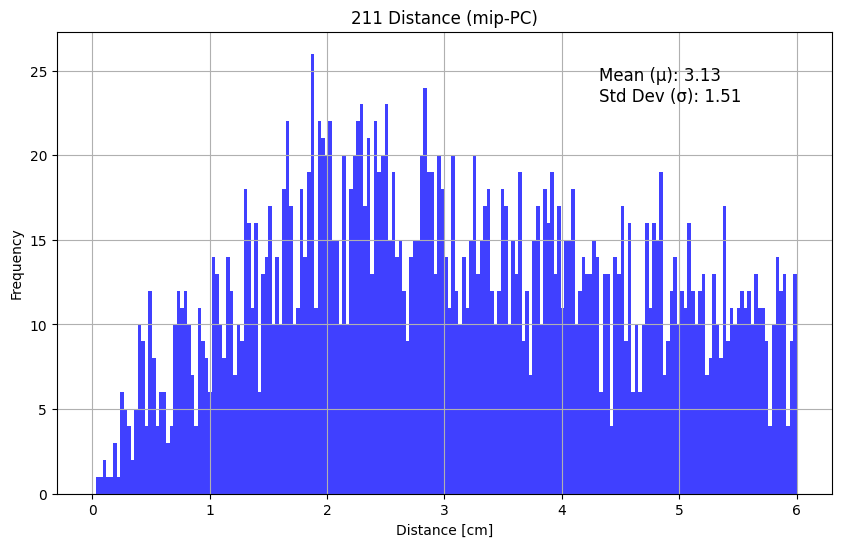

Plot saved to component_distance2


In [ ]:
#def plot_distance_histogram(df, output_file, bins=30, range = (-12, 12), title = "placeholder"):
plot_distance_histogram(combined_df, 'component_distance2', bins = 200, range = (-16, 6), title = "211")
#plot_distance_histogram(combined_df2, 'component_distance2', bins = 200, range = (-16, 6), title = "211 MIP DS")



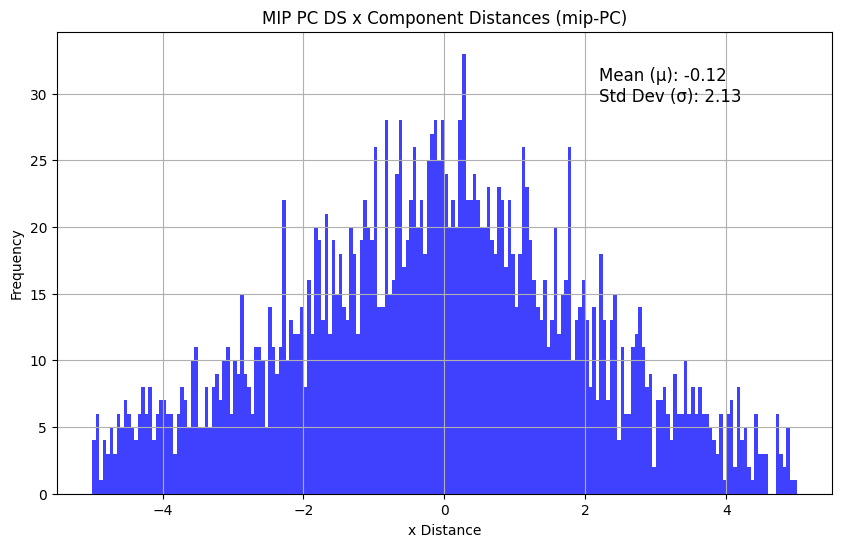

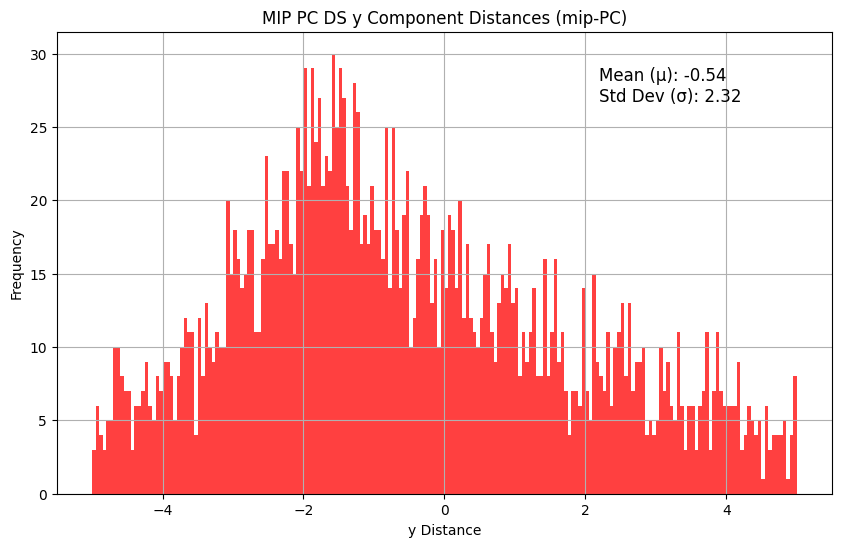

Plots saved to component_distance_x.png and component_distance_y.png


In [ ]:
plot_component_distance_histograms(combined_df, 'component_distance', bins = 200, range = (-5, 5), title = "MIP PC DS")
#plot_component_distance_histograms(combined_df2, 'component_distance2', bins = 200, range = (-5, 5), title = "211 MIP DS")


In [ ]:
plot_component_distance_histograms(combined_df, 'component_distance2', bins = 200, range = (-5, 5), title = "MIP PC DS")
plot_component_distance_histograms(combined_df2, 'component_distance2', bins = 200, range = (-5, 5), title = "211 MIP DS")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def plot_numerical_histogram_nparr(data_array, output_file, **kwargs):
    # Pre-process the data if a range is specified.
    if 'range' in kwargs:
        range_min, range_max = kwargs['range']
        data_array = data_array[(data_array >= range_min) & (data_array <= range_max)]

    # Filter out NaN values from data
    clean_data = data_array[~np.isnan(data_array)]

    # Determine the number of bins
    num_bins = kwargs.pop('bins', 'auto')  # Use 'auto' as default if bins not specified in kwargs

    # Create the histogram
    n, bins, patches = plt.hist(clean_data, bins=num_bins, alpha=0.75, color='blue', **kwargs)

    # Calculate bin centers from bin edges
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Fit the Gaussian function to the histogram data
    popt, _ = curve_fit(gaussian, bin_centers, n, p0=[max(n), np.mean(clean_data), np.std(clean_data)])

    # Plot the Gaussian fit
    x_interval_for_fit = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='red')

    # Annotate with the fit parameters
    plt.annotate(f'Mean (µ): {popt[1]:.4f}\nStd Dev (σ): {popt[2]:.4f}',
                 xy=(0.65, 0.55), xycoords='axes fraction', fontsize=12)

    # Set titles and labels
    plt.title(output_file)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()  # Show legend to indicate the Gaussian fit line
    plt.savefig(output_file)  # Save the figure to a file
    plt.show()  # Display the plot
    plt.close()  # Close the plot figure to free up memory
    print(f"Plot saved to {output_file}")

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def plot_numerical_histogram_nparr(data_array, output_file, **kwargs):
    # Pre-process the data if a range is specified.
    if 'range' in kwargs:
        range_min, range_max = kwargs['range']
        data_array = data_array[(data_array >= range_min) & (data_array <= range_max)]

    # Filter out NaN values from data
    clean_data = data_array[~np.isnan(data_array)]

    # Determine the number of bins
    num_bins = kwargs.pop('bins', 'auto')  # Use 'auto' as default if bins not specified in kwargs

    # Create the histogram
    n, bins, patches = plt.hist(clean_data, bins=num_bins, alpha=0.75, color='blue', **kwargs)

    # Calculate bin centers from bin edges
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Fit the Gaussian function to the histogram data
    popt, _ = curve_fit(gaussian, bin_centers, n, p0=[max(n), np.mean(clean_data), np.std(clean_data)])

    # Plot the Gaussian fit
    x_interval_for_fit = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='red')

    # Annotate with the fit parameters
    plt.annotate(f'Mean (µ): {popt[1]:.4f}\nStd Dev (σ): {popt[2]:.4f}',
                 xy=(0.65, 0.55), xycoords='axes fraction', fontsize=12)

    # Set titles and labels
    plt.title(output_file)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()  # Show legend to indicate the Gaussian fit line
    plt.savefig(output_file)  # Save the figure to a file
    plt.show()  # Display the plot
    plt.close()  # Close the plot figure to free up memory
    print(f"Plot saved to {output_file}")

def plot_numerical_histogram_nparr2(data_array, output_file, **kwargs):
    """
    Plots a numerical histogram for a specified NumPy array and saves it as a file.

    Args:
    data_array (numpy.ndarray): Array containing the numerical data.
    output_file (str): File path where the plot will be saved.
    """
    if 'range' in kwargs:
        range_min, range_max = kwargs['range']
        data_array = data_array[(data_array >= range_min) & (data_array <= range_max)]


    plt.figure(figsize=(10, 6))
    plt.hist(data_array[~np.isnan(data_array)], alpha=0.75, color='blue', **kwargs)  # Handle NaN values



    mean = np.mean(data_array)
    std = np.std(data_array)
    plt.annotate(f'Mean (µ): {mean:.3f}\nStd Dev (σ): {std:.5f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)

    plt.title(output_file)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(output_file)  # Save the figure to a file
    plt.show()  # Close the plot figure to free up memory
    plt.close()  # Close the plot figure to free up memory
    print(f"Plot saved to {output_file}")


def plot_numerical_histogram_nparr2(data_array, output_file, **kwargs):
    """
    Plots a numerical histogram for a specified NumPy array and saves it as a file.

    Args:
    data_array (numpy.ndarray): Array containing the numerical data.
    output_file (str): File path where the plot will be saved.
    """
    if 'range' in kwargs:
        range_min, range_max = kwargs['range']
        data_array = data_array[(data_array >= range_min) & (data_array <= range_max)]


    plt.figure(figsize=(10, 6))

    plt.hist(data_array[~np.isnan(data_array)], alpha=0.75, color='blue', **kwargs)  # Handle NaN values



    mean = np.mean(data_array)
    std = np.std(data_array)
    plt.annotate(f'Mean (µ): {mean:.3f}\nStd Dev (σ): {std:.5f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)

    plt.title(output_file)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(output_file)  # Save the figure to a file
    plt.show()  # Close the plot figure to free up memory
    plt.close()  # Close the plot figure to free up memory
    print(f"Plot saved to {output_file}")

## Plot Ckov photons histograms




In [ ]:
def print_dict_structure(data):
    for key, value in data.items():
        if isinstance(value, dict):
            print(f"Key: {key} (dict)")
            print_dict_structure(value)  # Recursively print dictionary content
        elif isinstance(value, np.ndarray):
            print(f"Key: {key} (numpy array) - Shape: {value.shape}")
        elif isinstance(value, pd.Series):
            print(f"Key: {key} (pandas Series) - Length: {len(value)}")
        else:
            print(f"Key: {key} - Type: {type(value)}")

#print_dict_structure(all_dicts)



ckov_recon shape (4134, 1)
ckov_recon_mh shape (4134, 1)
momentum shape (4134,)
pdg shape (4134,)
z_proton shape (4134, 57)
mask shape (4134, 57)
sums shape (4134,)
sum : m_cut_l 3369, m_cut_h 2913, mip2pc_cut 2149 pdg_cut2 4117
sum : sum_mask 1014


<ipython-input-83-d9c59e497f1a>:77: RuntimeWarning: divide by zero encountered in divide
  z_proton = (theta_cer-th_proton2)/sigma_ring


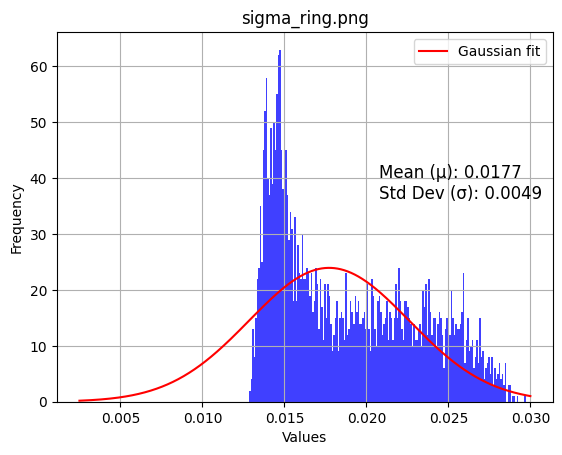

Plot saved to sigma_ring.png


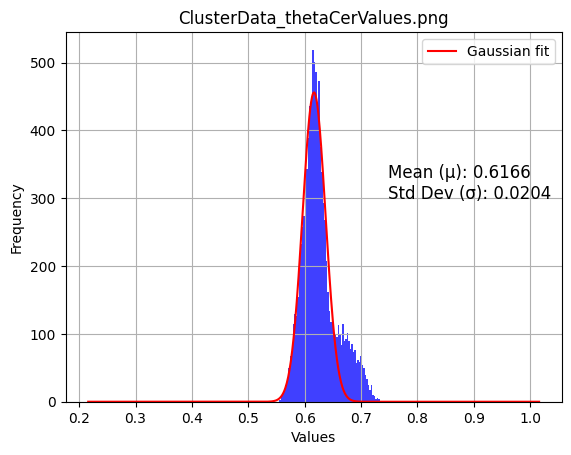

Plot saved to ClusterData_thetaCerValues.png


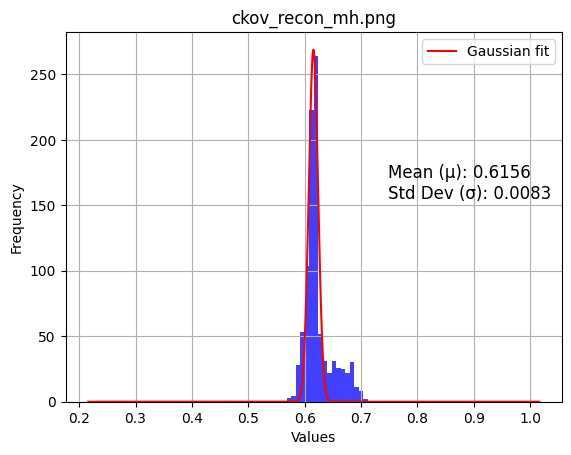

Plot saved to ckov_recon_mh.png


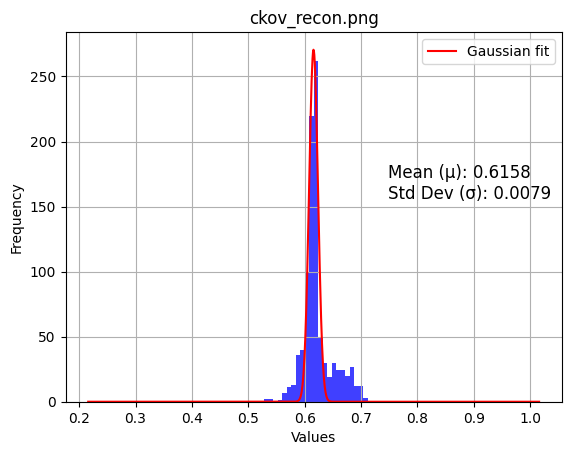

Plot saved to ckov_recon.png
shape th_proton (4134,) > shape ckov_recon_mh (4134,)
shape diff (988,)


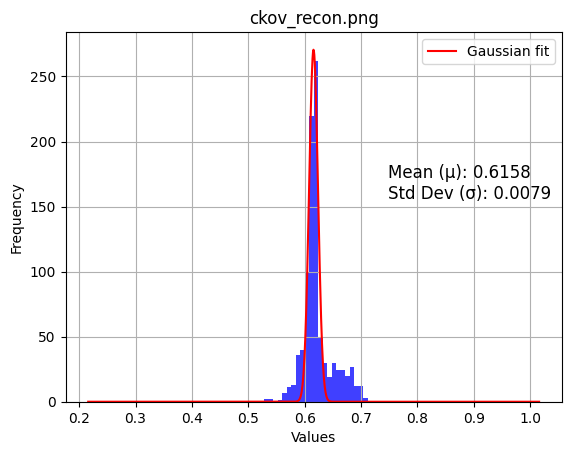

Plot saved to ckov_recon.png


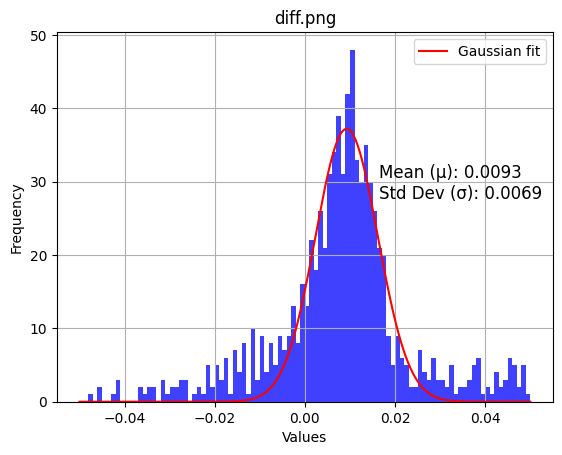

Plot saved to diff.png


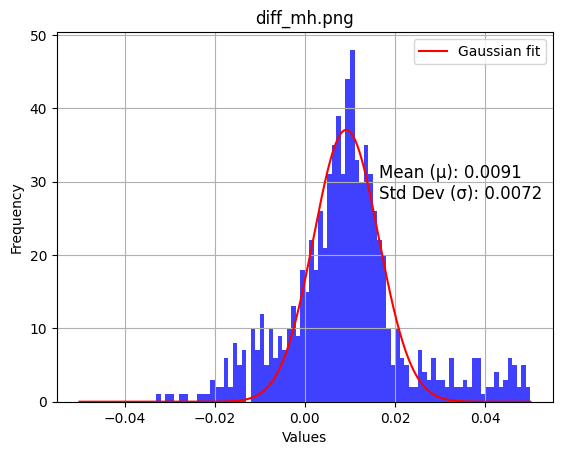

Plot saved to diff_mh.png


In [ ]:


# Key: TrackAttributes_xMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_thetaPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_phiPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_momentumThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_qMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_sizeMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_mipPcDistThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThPionThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThKaonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThProtonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_refIndexThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconMassHypThisTrack (pandas Series) - Length: 1220


sigma_ring = np.asarray(all_dicts["ClusterCandidates;1"]["ClusterData_sigmaRingValues"])
theta_cer = all_dicts["ClusterCandidates;1"]["ClusterData_thetaCerValues"]

ckov_recon2 = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
ckov_recon_mh2 = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]).reshape(-1, 1)
print(f"ckov_recon shape {ckov_recon2.shape}")
print(f"ckov_recon_mh shape {ckov_recon_mh2.shape}")

ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"])
ckov_recon_mh = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])

momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
pdg = all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"]



th_pion = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"])
th_kaon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"])
th_proton = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"])




print(f"momentum shape {momentum.shape}")
print(f"pdg shape {pdg.shape}")



cor_map = all_dicts["McTruth;1"]["mcTruth_isMipMatchedCorrectly"]
cor_map_mask = cor_map == True

mom_cut_l = momentum > 2.6# & momentum < 2.8

xMip = all_dicts["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
yMip = all_dicts["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
xpc = all_dicts["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
ypc = all_dicts["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

dx = xMip - xpc
dy = yMip - ypc

dist = np.sqrt(dx*dx + dy*dy)

#mip2pc = combined_df["component_distance2"]
#mip2pc = combined_df["component_distance2"]



protonProbs  = all_dicts["ClusterCandidates;1"]["ClusterData_protonProbs"]

kaonProbs  = all_dicts["ClusterCandidates;1"]["ClusterData_kaonProbs"]
pionProbs  = all_dicts["ClusterCandidates;1"]["ClusterData_pionProbs"]


th_proton2 = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]).reshape(-1, 1)

z_proton = (theta_cer-th_proton2)/sigma_ring

print(f"z_proton shape {z_proton.shape}")


# Create a mask where these sums are greater than 5
mask = np.abs(z_proton) < 2
print(f"mask shape {mask.shape}")
sums = np.count_nonzero(mask, axis=1)

sum_mask = sums > 3

# Optionally, if you need to filter the original array based on this mask:
filtered_protonProbs = protonProbs[mask]
filtered_kaonProbs = kaonProbs[mask]
filtered_pionProbs = pionProbs[mask]



print(f"sums shape {sums.shape}")

mom_cut_l = momentum > 2.6# & momentum < 2.8
mom_cut_h = momentum < 2.7
mip2pc_cut = dist < 2
pdg_cut2 = abs(pdg) == 2212
pdg_cut = pdg_cut2 & cor_map_mask




print(f"sum : m_cut_l {mom_cut_l.sum()}, m_cut_h {mom_cut_h.sum()}, mip2pc_cut {mip2pc_cut.sum()} pdg_cut2 {pdg_cut2.sum()}")
print(f"sum : sum_mask {sum_mask.sum()}")

#plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'sigma_ring.png', bins=300, range = (300, 1.5e10))

plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut & sum_mask], 'sigma_ring.png',  bins=300, range = (0.0025, 0.03))

sigma = 0.2
mean = 0.616
range = (mean-2*sigma, mean+2*sigma)


plot_numerical_histogram_nparr(theta_cer[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ClusterData_thetaCerValues.png', bins=300, range = range)


sigma = 0.2
range = (mean-2*sigma, mean+2*sigma)

plot_numerical_histogram_nparr(ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon_mh.png', bins=100, range = range)
plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)
#plot_numerical_histogram_nparr(ckov_recon, 'ckov_recon.png', bins=30, range = (0.25, 0.8))
#plot_numerical_histogram_nparr(ckov_recon_mh, 'ckov_recon_mh.png', bins=300, range = (0.25, 0.8))

#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconMassHypThisTrack', "TrackAttributes_ckovReconMassHypThisTrack", range = (0.1, 0.8), bins = 200)
#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconThisTrack', "TrackAttributes_ckovReconThisTrack", range = (0.1, 0.8), bins = 200)


diff_mh = ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]

diff = ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]


#diff = ckov_recon - th_proton
#diff_mh = ckov_recon_mh - th_proton

print(f"shape th_proton {th_proton.shape} > shape ckov_recon_mh {ckov_recon_mh.shape}")


print(f"shape diff {diff.shape}")


plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)


plot_numerical_histogram_nparr(diff, 'diff.png', bins=100, range = (-0.05, 0.05))
plot_numerical_histogram_nparr(diff_mh, 'diff_mh.png', bins=100, range = (-0.05, 0.05))




## Other Fields

In [ ]:

file_name3 = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/lococc/mergedBothPc.root'
combined_df3, all_dicts3 = test2_file(file_name3)

file_name2 = '/content/drive/MyDrive/ColabNotebooks/CERN_ML/CNN_PID/root2Pandas/lococc/mergedBothMip.root'
combined_df2, all_dicts2 = test2_file(file_name2)

# Key: TrackAttributes_xMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_thetaPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_phiPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_momentumThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_qMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_sizeMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_mipPcDistThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThPionThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThKaonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThProtonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_refIndexThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconMassHypThisTrack (pandas Series) - Length: 1220


sigma_ring = np.asarray(all_dicts2["ClusterCandidates;1"]["ClusterData_sigmaRingValues"])
theta_cer = all_dicts2["ClusterCandidates;1"]["ClusterData_thetaCerValues"]

ckov_recon2 = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
ckov_recon_mh2 = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]).reshape(-1, 1)
print(f"ckov_recon shape {ckov_recon2.shape}")
print(f"ckov_recon_mh shape {ckov_recon_mh2.shape}")

ckov_recon = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"])
ckov_recon_mh = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])

momentum = all_dicts2["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
pdg = all_dicts2["McTruth;1"]["mcTruth_pdgCodeTrack;"]



th_pion = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"])
th_kaon = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"])
th_proton = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"])




print(f"momentum shape {momentum.shape}")
print(f"pdg shape {pdg.shape}")



cor_map = all_dicts2["McTruth;1"]["mcTruth_isMipMatchedCorrectly"]
cor_map_mask = cor_map == True

mom_cut_l = momentum > 2.6# & momentum < 2.8

xMip = all_dicts2["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
yMip = all_dicts2["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
xpc = all_dicts2["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
ypc = all_dicts2["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

dx = xMip - xpc
dy = yMip - ypc

dist = np.sqrt(dx*dx + dy*dy)

#mip2pc = combined_df["component_distance2"]
#mip2pc = combined_df["component_distance2"]



protonProbs  = all_dicts2["ClusterCandidates;1"]["ClusterData_protonProbs"]

kaonProbs  = all_dicts2["ClusterCandidates;1"]["ClusterData_kaonProbs"]
pionProbs  = all_dicts2["ClusterCandidates;1"]["ClusterData_pionProbs"]


th_proton2 = np.asarray(all_dicts2["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]).reshape(-1, 1)

z_proton = (theta_cer-th_proton2)/sigma_ring

print(f"z_proton shape {z_proton.shape}")


# Create a mask where these sums are greater than 5
mask = np.abs(z_proton) < 2
print(f"mask shape {mask.shape}")
sums = np.count_nonzero(mask, axis=1)

sum_mask = sums > 3

# Optionally, if you need to filter the original array based on this mask:
filtered_protonProbs = protonProbs[mask]
filtered_kaonProbs = kaonProbs[mask]
filtered_pionProbs = pionProbs[mask]



print(f"sums shape {sums.shape}")

mom_cut_l = momentum > 2.6# & momentum < 2.8
mom_cut_h = momentum < 2.7
mip2pc_cut = dist < 2
pdg_cut2 = abs(pdg) == 2212
pdg_cut = pdg_cut2 & cor_map_mask





print(f"sum : m_cut_l {mom_cut_l.sum()}, m_cut_h {mom_cut_h.sum()}, mip2pc_cut {mip2pc_cut.sum()} pdg_cut2 {pdg_cut2.sum()}")
print(f"sum : sum_mask {sum_mask.sum()}")

#plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'sigma_ring.png', bins=300, range = (300, 1.5e10))

plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut & sum_mask], 'sigma_ring.png',  bins=300, range = (0.0025, 0.03))

sigma = 0.2
mean = 0.616
range = (mean-2*sigma, mean+2*sigma)


plot_numerical_histogram_nparr(theta_cer[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ClusterData_thetaCerValues.png', bins=300, range = range)


sigma = 0.2
range = (mean-2*sigma, mean+2*sigma)

plot_numerical_histogram_nparr(ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon_mh.png', bins=100, range = range)
plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)
#plot_numerical_histogram_nparr(ckov_recon, 'ckov_recon.png', bins=30, range = (0.25, 0.8))
#plot_numerical_histogram_nparr(ckov_recon_mh, 'ckov_recon_mh.png', bins=300, range = (0.25, 0.8))

#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconMassHypThisTrack', "TrackAttributes_ckovReconMassHypThisTrack", range = (0.1, 0.8), bins = 200)
#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconThisTrack', "TrackAttributes_ckovReconThisTrack", range = (0.1, 0.8), bins = 200)


diff_mh = ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]

diff = ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]


#diff = ckov_recon - th_proton
#diff_mh = ckov_recon_mh - th_proton

print(f"shape th_proton {th_proton.shape} > shape ckov_recon_mh {ckov_recon_mh.shape}")


print(f"shape diff {diff.shape}")


plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)


plot_numerical_histogram_nparr(diff, 'diff.png', bins=100, range = (-0.05, 0.05))
plot_numerical_histogram_nparr(diff_mh, 'diff_mh.png', bins=100, range = (-0.05, 0.05))




In [ ]:


# Key: TrackAttributes_xMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yRadThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_xPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_yPCThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_thetaPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_phiPThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_momentumThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_qMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_sizeMipThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_mipPcDistThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThPionThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThKaonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovThProtonThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_refIndexThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconThisTrack (pandas Series) - Length: 1220
# Key: TrackAttributes_ckovReconMassHypThisTrack (pandas Series) - Length: 1220


sigma_ring = np.asarray(all_dicts3["ClusterCandidates;1"]["ClusterData_sigmaRingValues"])
theta_cer = all_dicts3["ClusterCandidates;1"]["ClusterData_thetaCerValues"]

ckov_recon2 = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
ckov_recon_mh2 = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]).reshape(-1, 1)
print(f"ckov_recon shape {ckov_recon2.shape}")
print(f"ckov_recon_mh shape {ckov_recon_mh2.shape}")

ckov_recon = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"])
ckov_recon_mh = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])

momentum = all_dicts3["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
pdg = all_dicts3["McTruth;1"]["mcTruth_pdgCodeTrack;"]



th_pion = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"])
th_kaon = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"])
th_proton = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"])




print(f"momentum shape {momentum.shape}")
print(f"pdg shape {pdg.shape}")



cor_map = all_dicts3["McTruth;1"]["mcTruth_isMipMatchedCorrectly"]
cor_map_mask = cor_map == True

mom_cut_l = momentum > 2.6# & momentum < 2.8

xMip = all_dicts3["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
yMip = all_dicts3["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
xpc = all_dicts3["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
ypc = all_dicts3["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

dx = xMip - xpc
dy = yMip - ypc

dist = np.sqrt(dx*dx + dy*dy)

#mip2pc = combined_df["component_distance2"]
#mip2pc = combined_df["component_distance2"]



protonProbs  = all_dicts3["ClusterCandidates;1"]["ClusterData_protonProbs"]

kaonProbs  = all_dicts3["ClusterCandidates;1"]["ClusterData_kaonProbs"]
pionProbs  = all_dicts3["ClusterCandidates;1"]["ClusterData_pionProbs"]


th_proton2 = np.asarray(all_dicts3["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]).reshape(-1, 1)

z_proton = (theta_cer-th_proton2)/sigma_ring

print(f"z_proton shape {z_proton.shape}")


# Create a mask where these sums are greater than 5
mask = np.abs(z_proton) < 2
print(f"mask shape {mask.shape}")
sums = np.count_nonzero(mask, axis=1)

sum_mask = sums > 3

# Optionally, if you need to filter the original array based on this mask:
filtered_protonProbs = protonProbs[mask]
filtered_kaonProbs = kaonProbs[mask]
filtered_pionProbs = pionProbs[mask]



print(f"sums shape {sums.shape}")

mom_cut_l = momentum > 2.6# & momentum < 2.8
mom_cut_h = momentum < 2.7
mip2pc_cut = dist < 2
pdg_cut2 = abs(pdg) == 2212
pdg_cut = pdg_cut2 & cor_map_mask





print(f"sum : m_cut_l {mom_cut_l.sum()}, m_cut_h {mom_cut_h.sum()}, mip2pc_cut {mip2pc_cut.sum()} pdg_cut2 {pdg_cut2.sum()}")
print(f"sum : sum_mask {sum_mask.sum()}")

#plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'sigma_ring.png', bins=300, range = (300, 1.5e10))

plot_numerical_histogram_nparr(sigma_ring[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut & sum_mask], 'sigma_ring.png',  bins=300, range = (0.0025, 0.03))

sigma = 0.2
mean = 0.616
range = (mean-2*sigma, mean+2*sigma)


plot_numerical_histogram_nparr(theta_cer[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ClusterData_thetaCerValues.png', bins=300, range = range)


sigma = 0.2
range = (mean-2*sigma, mean+2*sigma)

plot_numerical_histogram_nparr(ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon_mh.png', bins=100, range = range)
plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)
#plot_numerical_histogram_nparr(ckov_recon, 'ckov_recon.png', bins=30, range = (0.25, 0.8))
#plot_numerical_histogram_nparr(ckov_recon_mh, 'ckov_recon_mh.png', bins=300, range = (0.25, 0.8))

#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconMassHypThisTrack', "TrackAttributes_ckovReconMassHypThisTrack", range = (0.1, 0.8), bins = 200)
#plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconThisTrack', "TrackAttributes_ckovReconThisTrack", range = (0.1, 0.8), bins = 200)


diff_mh = ckov_recon_mh[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]

diff = ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut] - th_proton[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut]


#diff = ckov_recon - th_proton
#diff_mh = ckov_recon_mh - th_proton

print(f"shape th_proton {th_proton.shape} > shape ckov_recon_mh {ckov_recon_mh.shape}")


print(f"shape diff {diff.shape}")


plot_numerical_histogram_nparr(ckov_recon[pdg_cut & mom_cut_l & mom_cut_h & mip2pc_cut], 'ckov_recon.png', bins=100, range = range)


plot_numerical_histogram_nparr(diff, 'diff.png', bins=100, range = (-0.05, 0.05))
plot_numerical_histogram_nparr(diff_mh, 'diff_mh.png', bins=100, range = (-0.05, 0.05))




In [ ]:
plot_numerical_histogram(combined_df, 'TrackAttributes_momentumThisTrack', "TrackAttributes_momentumThisTrack", bins = 100, range = (2,3))


In [ ]:
all_dicts["SumProballTracks;1"]["sumProbabilityAllTracks"]
all_dicts["ThisTrack;1"]#["sumProbabilityAllTracks"]
all_dicts["HighChargeClusters;1"]#["sumProbabilityAllTracks"]
all_dicts["ClusterCandidates;1"]#["sumProbabilityAllTracks"]
all_dicts["OtherTracks;1"]#["sumProbabilityAllTracks"]
all_dicts["McTruth;1"]#["sumProbabilityAllTracks"]


In [ ]:
## Track values

In [ ]:
plot_numerical_histogram(combined_df, 'TrackAttributes_mipPcDistThisTrack', "TrackAttributes_mipPcDistThisTrack", range = (0.01, 10), bins = 200)





#plot_numerical_histogram(combined_df, 'TrackAttributes_mipPcDistThisTrack', "TrackAttributes_mipPcDistThisTrack")


In [ ]:



plot_numerical_histogram(combined_df, 'TrackAttributes_mipPcDistThisTrack', "TrackAttributes_mipPcDistThisTrack", range = (0.01, 10), bins = 200)

plot_numerical_histogram(combined_df2, 'TrackAttributes_mipPcDistThisTrack2', "TrackAttributes_mipPcDistThisTrack", range = (0.01, 10), bins = 200)


In [ ]:


plot_numerical_histogram_nparr(all_dicts["ClusterCandidates;1"]["ClusterData_thetaCerValues"], 'ClusterData_thetaCerValues.png', bins=300, range = (0.25, 0.8))

plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconMassHypThisTrack', "TrackAttributes_ckovReconMassHypThisTrack", range = (0.1, 0.8), bins = 200)
plot_numerical_histogram(combined_df, 'TrackAttributes_ckovReconThisTrack', "TrackAttributes_ckovReconThisTrack", range = (0.1, 0.8), bins = 200)




#plot_numerical_histogram(combined_df, 'TrackAttributes_mipPcDistThisTrack', "TrackAttributes_mipPcDistThisTrack")


In [ ]:
plot_numerical_histogram_nparr(all_dicts2["ClusterCandidates;1"]["ClusterData_thetaCerValues"], 'ClusterData_thetaCerValues.png', bins=300, range = (0.25, 0.8))

plot_numerical_histogram(combined_df2, 'TrackAttributes_ckovReconMassHypThisTrack', "TrackAttributes_ckovReconMassHypThisTrack", range = (0.1, 0.8), bins = 200)
plot_numerical_histogram(combined_df2, 'TrackAttributes_ckovReconThisTrack', "TrackAttributes_ckovReconThisTrack", range = (0.1, 0.8), bins = 200)

## Plot photon values

In [ ]:
plot_numerical_histogram_nparr(th_pion[mom_cut_l & mom_cut_h & mip2pc_cut], 'th_pion.png', bins=50, range = (0.55, 0.7))
plot_numerical_histogram_nparr(th_kaon[mom_cut_l & mom_cut_h & mip2pc_cut], 'th_kaon.png', bins=50, range = (0.55, 0.7))
plot_numerical_histogram_nparr(th_proton[mom_cut_l & mom_cut_h & mip2pc_cut], 'th_proton.png', bins=50, range = (0.55, 0.7))


plot_numerical_histogram_nparr(protonProbs, 'filtered_protonProbs.png', bins=100, range = (0.001, 1))

plot_numerical_histogram_nparr(filtered_protonProbs, 'filtered_protonProbs.png', bins=100, range = (0.001, 1))
plot_numerical_histogram_nparr(filtered_kaonProbs, 'filtered_kaonProbs.png', bins=100, range = (0.001, 1))
plot_numerical_histogram_nparr(filtered_pionProbs, 'filtered_pionProbs.png', bins=100, range = (0.001, 1))


In [ ]:


plot_numerical_histogram(all_dicts[ClusterData_sigmaRingValues] , "ClusterData_sigmaRingValues")
plot_numerical_histogram(combined_df, 'ClusterData_thetaCerValues', "ClusterData_thetaCerValues")

track_pdg = combined_df[combined_df["mcTruth_pdgCodeTrack;"] != -1]["mcTruth_pdgCodeTrack;"].dropna()

print(track_pdg)


print(combined_df["sumProbabilityAllTracks"].shape)


dist_cut = combined_df['TrackAttributes_mipPcDistThisTrack'] < 2
mcutl = combined_df['TrackAttributes_momentumThisTrack'] < 2.8
mcuth = combined_df['TrackAttributes_momentumThisTrack'] > 2.6


cut_combined = dist_cut & mcutl & mcuth



plot_ckovRecon_by_pdg(df=combined_df, pdg_codes=[211, 321, 2212])
print_column_shapes(combined_df)

## Create map

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions8.py
from misc_helper_functions8 import *

--2024-04-18 19:32:19--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions8.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33663 (33K) [text/plain]
Saving to: ‘misc_helper_functions8.py’

misc_helper_functio 100%[===================>]  32.87K  --.-KB/s    in 0s      

2024-04-18 19:32:19 (136 MB/s) - ‘misc_helper_functions8.py’ saved [33663/33663]



In [ ]:
extract_neighborhood_map(candidate_positions = X_pion_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)

# Misc plots

## Scatter plots

<ipython-input-208-c5935588ef3a>:19: RuntimeWarning: divide by zero encountered in divide
  angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
<ipython-input-208-c5935588ef3a>:19: RuntimeWarning: invalid value encountered in arccos
  angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
<ipython-input-208-c5935588ef3a>:20: RuntimeWarning: divide by zero encountered in divide
  angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
<ipython-input-208-c5935588ef3a>:20: RuntimeWarning: invalid value encountered in arccos
  angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
<ipython-input-208-c5935588ef3a>:21: RuntimeWarning: divide by zero encountered in divide
  angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))
<ipython-input-208-c5935588ef3a>:21: RuntimeWarning: invalid value encountered in arccos
  angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))


ckov_recon_mask shape (4956,) 
ckov_recon shape (4956,) 
dist shape (4956,) 
dist_mask shape (4956,) 


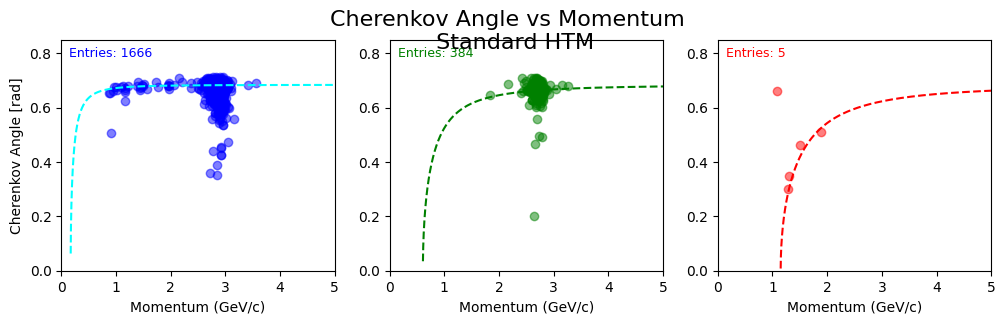

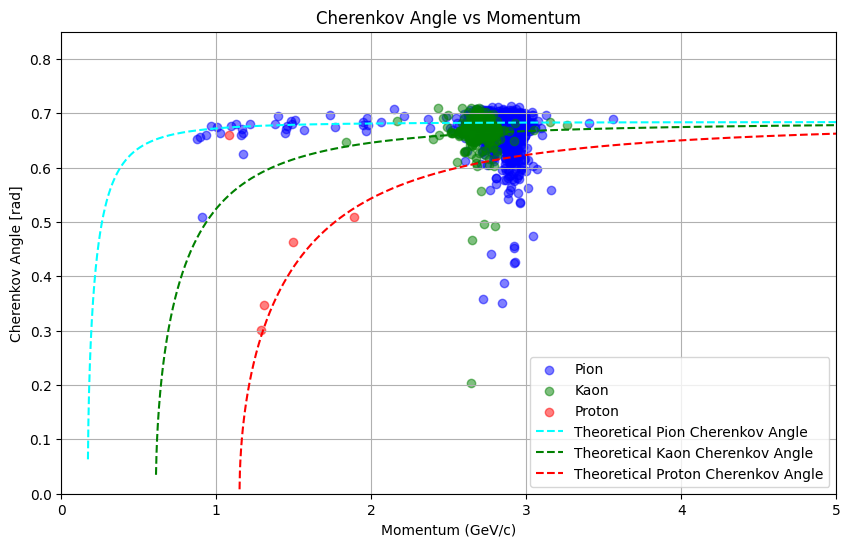

In [ ]:
def specie_scatter_plots():
    # Prepare the data
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    ckov_recon = combined_df['TrackAttributes_ckovReconThisTrack']
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"])
    ckov_recon_mh2 = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]

    ckov_recon_mask = (ckov_recon>0) & (ckov_recon<1)

    p = np.linspace(0, 5, 5000)
    mass_pion = 0.1396
    mass_kaon = 0.497648
    mass_proton = 0.938

    angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
    angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
    angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))

    xMip = all_dicts["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
    yMip = all_dicts["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
    xpc = all_dicts["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
    ypc = all_dicts["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

    print(f"ckov_recon_mask shape {ckov_recon_mask.shape} ")
    print(f"ckov_recon shape {ckov_recon.shape} ")

    dx = xMip - xpc
    dy = yMip - ypc

    dist = np.sqrt(dx*dx + dy*dy)
    dist_mask = dist < 2

    print(f"dist shape {dist.shape} ")
    print(f"dist_mask shape {dist_mask.shape} ")

    th_pion = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"])
    th_kaon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"])
    th_proton = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"])
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    fig.suptitle('Cherenkov Angle vs Momentum \n Standard HTM\n', fontsize=12)

    # Set up the scatter plot
    plt.figure(figsize=(10, 6))
    i = 0
    for specie, color, label in zip([211, 321, 2212], ['blue', 'green', 'red'], ['Pion', 'Kaon', 'Proton']):
        specie_mask = (pdg == specie)

        momentum_masked = momentum[specie_mask & dist_mask & ckov_recon_mask]
        ckov_masked =  ckov_recon[specie_mask & dist_mask & ckov_recon_mask]

        num_entries = np.count_nonzero(ckov_masked)

        plt.scatter(momentum_masked, ckov_masked, alpha=0.5, label=label, color=color)
        axes[i].scatter(momentum_masked, ckov_masked, alpha=0.5, label=label, color=color)
        if i == 0:
            axes[i].plot(p, angle_pion, label='Theoretical Pion Cherenkov Angle', color='cyan', linestyle='--')
        elif i == 1:
            axes[i].plot(p, angle_kaon, label='Theoretical Kaon Cherenkov Angle', color='green', linestyle='--')
        elif i == 2:
            axes[i].plot(p, angle_proton, label='Theoretical Proton Cherenkov Angle', color='red', linestyle='--')
        axes[i].text(0.03, 0.97, f'Entries: {num_entries}', transform=axes[i].transAxes,
                     fontsize=9, color=color, verticalalignment='top')

        axes[i].set_xlim(0, 5)
        axes[i].set_ylim(0, 0.85)

        if i == 0:
            axes[i].set_ylabel('Cherenkov Angle [rad]')

        axes[i].set_xlabel('Momentum (GeV/c)')
        i += 1

    plt.plot(p, angle_pion, label='Theoretical Pion Cherenkov Angle', color='cyan', linestyle='--')
    plt.plot(p, angle_kaon, label='Theoretical Kaon Cherenkov Angle', color='green', linestyle='--')
    plt.plot(p, angle_proton, label='Theoretical Proton Cherenkov Angle', color='red', linestyle='--')


    plt.xlim(0, 5)  # Example limits for momentum in GeV/c
    plt.ylim(0, .85)  # Example limits for Cherenkov angle in degrees


    plt.title('Cherenkov Angle vs Momentum')
    plt.xlabel('Momentum (GeV/c)')
    plt.ylabel('Cherenkov Angle [rad]')
    plt.legend()
    fig.suptitle('Cherenkov Angle vs Momentum \n Standard HTM\n', fontsize=16)

    plt.grid(True)
    plt.show()



specie_scatter_plots()

<ipython-input-209-d32b847771aa>:21: RuntimeWarning: divide by zero encountered in divide
  angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
<ipython-input-209-d32b847771aa>:21: RuntimeWarning: invalid value encountered in arccos
  angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
<ipython-input-209-d32b847771aa>:22: RuntimeWarning: divide by zero encountered in divide
  angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
<ipython-input-209-d32b847771aa>:22: RuntimeWarning: invalid value encountered in arccos
  angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
<ipython-input-209-d32b847771aa>:23: RuntimeWarning: divide by zero encountered in divide
  angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))
<ipython-input-209-d32b847771aa>:23: RuntimeWarning: invalid value encountered in arccos
  angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))


ckov_recon_mask shape (4956,) 
ckov_recon shape (4956,) 
dist shape (4956,) 
dist_mask shape (4956,) 


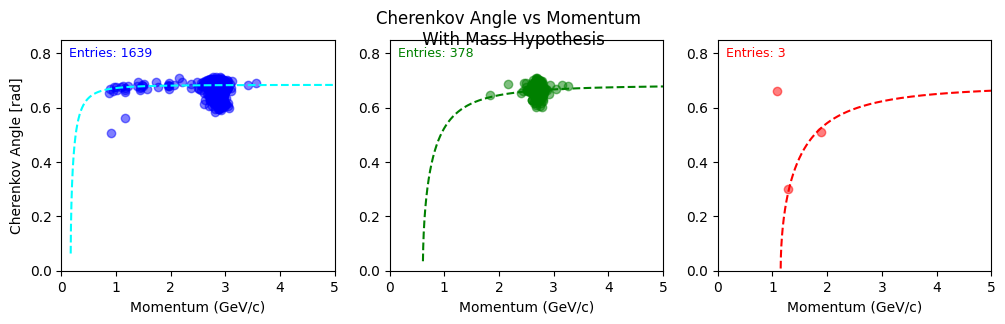

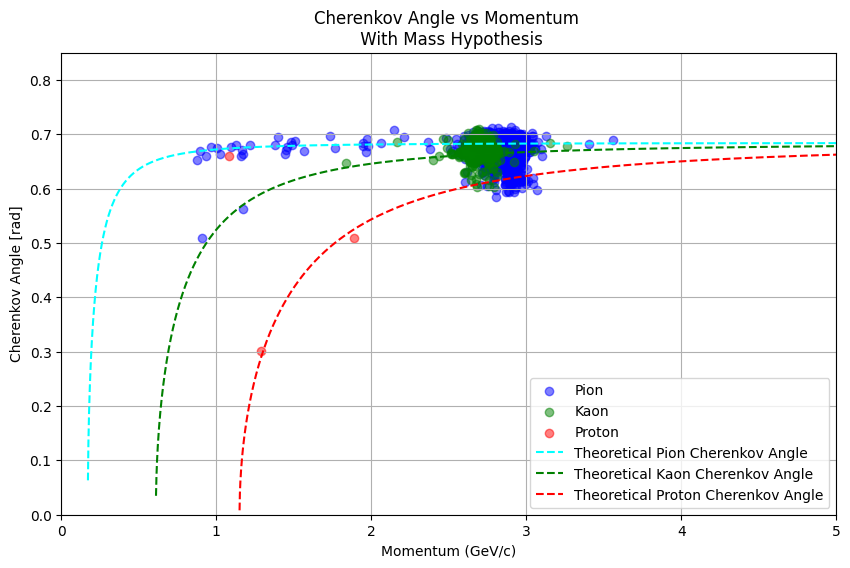

In [ ]:
def specie_scatter_plots():
    # Prepare the data
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    ckov_recon = combined_df['TrackAttributes_ckovReconThisTrack']
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)
    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]).reshape(-1, 1)

    ckov_recon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])
    ckov_recon_mh2 = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]

    ckov_recon_mh2_mask = ckov_recon_mh2>0
    ckov_recon_mask = (ckov_recon>0) & (ckov_recon<1)

    p = np.linspace(0, 5, 5000)
    mass_pion = 0.1396
    mass_kaon = 0.497648
    mass_proton = 0.938

    angle_pion = np.arccos(np.sqrt(p**2 + mass_pion**2) / (p * 1.2904))
    angle_kaon = np.arccos(np.sqrt(p**2 + mass_kaon**2) / (p * 1.2904))
    angle_proton = np.arccos(np.sqrt(p**2 + mass_proton**2) / (p * 1.2904))

    xMip = all_dicts["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
    yMip = all_dicts["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
    xpc = all_dicts["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
    ypc = all_dicts["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

    print(f"ckov_recon_mask shape {ckov_recon_mask.shape} ")
    print(f"ckov_recon shape {ckov_recon.shape} ")

    dx = xMip - xpc
    dy = yMip - ypc

    dist = np.sqrt(dx*dx + dy*dy)
    dist_mask = dist < 2

    print(f"dist shape {dist.shape} ")
    print(f"dist_mask shape {dist_mask.shape} ")

    th_pion = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"])
    th_kaon = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"])
    th_proton = np.asarray(all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"])

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    fig.suptitle('Cherenkov Angle vs Momentum \n With Mass Hypothesis\n', fontsize=12)

    # Set up the scatter plot
    plt.figure(figsize=(10, 6))
    i = 0
    for specie, color, label in zip([211, 321, 2212], ['blue', 'green', 'red'], ['Pion', 'Kaon', 'Proton']):
        specie_mask = (pdg == specie)
        momentum_masked = momentum[specie_mask & dist_mask & ckov_recon_mask]
        ckov_masked =  ckov_recon[specie_mask & dist_mask & ckov_recon_mask]

        num_entries = np.count_nonzero(ckov_masked)

        plt.scatter(momentum_masked, ckov_masked, alpha=0.5, label=label, color=color)
        axes[i].scatter(momentum_masked, ckov_masked, alpha=0.5, label=label, color=color)
        axes[i].text(0.03, 0.97, f'Entries: {num_entries}', transform=axes[i].transAxes,
                     fontsize=9, color=color, verticalalignment='top')

        if i == 0:
            axes[i].plot(p, angle_pion, label='Theoretical Pion Cherenkov Angle', color='cyan', linestyle='--')
        elif i == 1:
            axes[i].plot(p, angle_kaon, label='Theoretical Kaon Cherenkov Angle', color='green', linestyle='--')
        elif i == 2:
            axes[i].plot(p, angle_proton, label='Theoretical Proton Cherenkov Angle', color='red', linestyle='--')

        axes[i].set_xlim(0, 5)
        axes[i].set_ylim(0, 0.85)
        if i == 0:
            axes[i].set_ylabel('Cherenkov Angle [rad]')

        axes[i].set_xlabel('Momentum (GeV/c)')

        i += 1



    plt.plot(p, angle_pion, label='Theoretical Pion Cherenkov Angle', color='cyan', linestyle='--')
    plt.plot(p, angle_kaon, label='Theoretical Kaon Cherenkov Angle', color='green', linestyle='--')
    plt.plot(p, angle_proton, label='Theoretical Proton Cherenkov Angle', color='red', linestyle='--')


    plt.xlim(0, 5)  # Example limits for momentum in GeV/c
    plt.ylim(0, .85)  # Example limits for Cherenkov angle in degrees



    plt.title('Cherenkov Angle vs Momentum')
    plt.xlabel('Momentum (GeV/c)')
    plt.ylabel('Cherenkov Angle [rad]')
    plt.legend()
    plt.title(f'Cherenkov Angle vs Momentum \n With Mass Hypothesis')

    plt.grid(True)
    plt.show()



specie_scatter_plots()

## Momentum Distributions

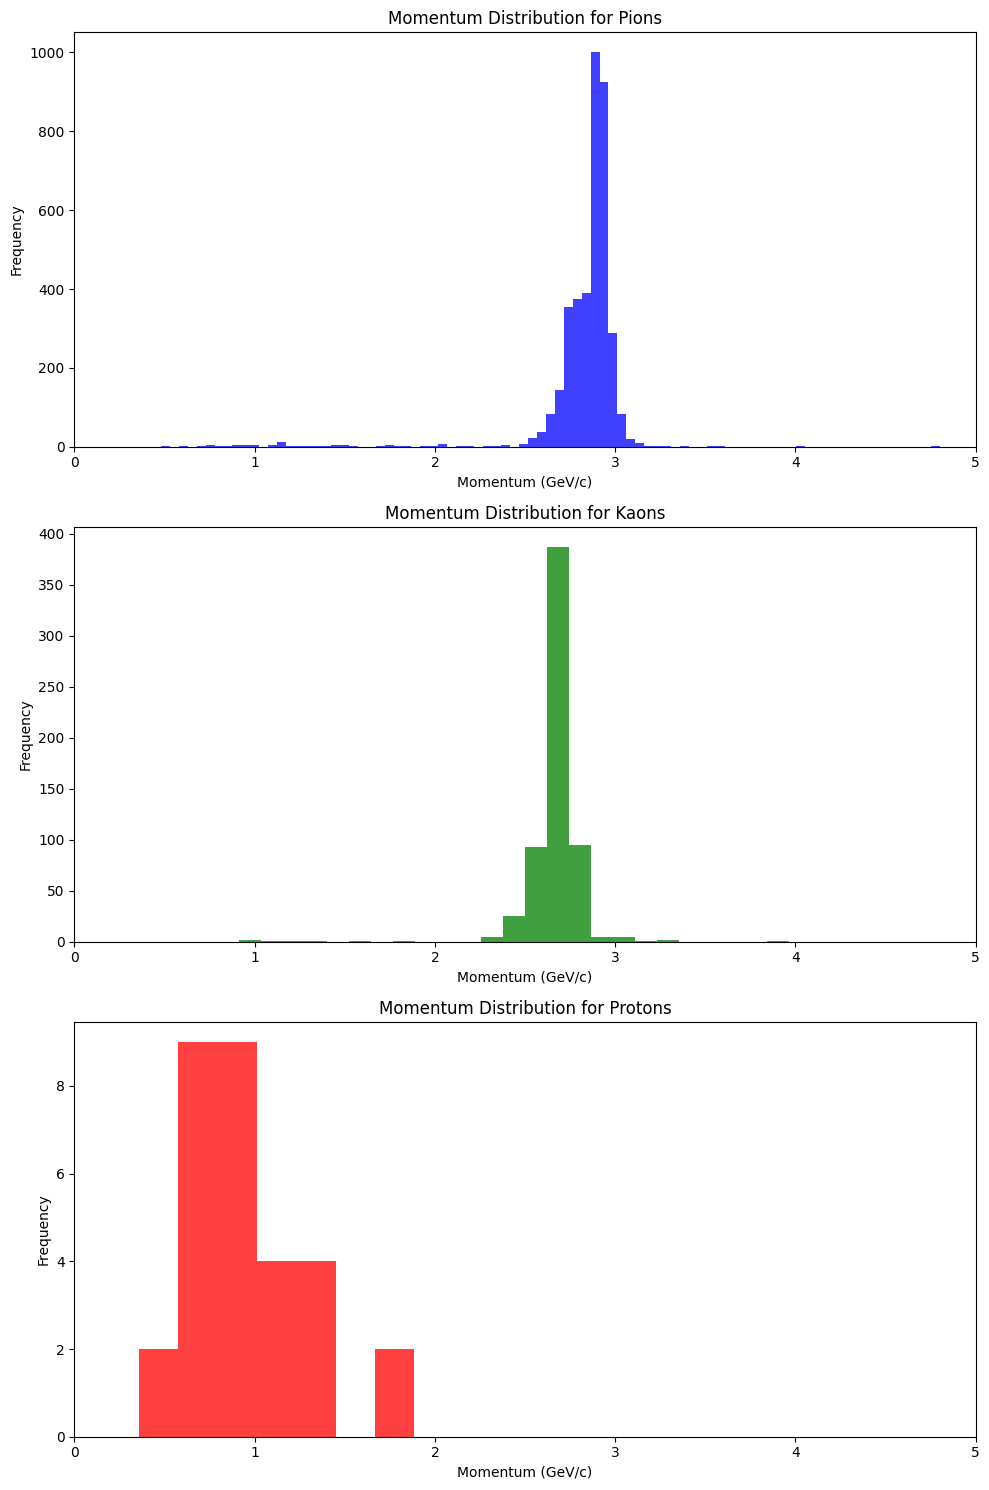

In [ ]:
def plot_momentum_per_specie():
    import matplotlib.pyplot as plt
    import numpy as np

    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]

    # Filtering data based on absolute PDG codes
    pions = momentum[pdg == 211]
    kaons = momentum[pdg == 321]
    protons = momentum[pdg == 2212]

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Plot histograms and set x-axis limits
    axes[0].hist(pions.dropna(), bins=100, color='blue', alpha=0.75)
    axes[0].set_title('Momentum Distribution for Pions')
    axes[0].set_xlabel('Momentum (GeV/c)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(0, 5)  # Set x-axis limits

    axes[1].hist(kaons.dropna(), bins=40, color='green', alpha=0.75)
    axes[1].set_title('Momentum Distribution for Kaons')
    axes[1].set_xlabel('Momentum (GeV/c)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlim(0, 5)  # Set x-axis limits

    axes[2].hist(protons.dropna(), bins='auto', color='red', alpha=0.75)
    axes[2].set_title('Momentum Distribution for Protons')
    axes[2].set_xlabel('Momentum (GeV/c)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xlim(0, 5)  # Set x-axis limits

    # Improve layout and display the plot
    plt.tight_layout()
    plt.show()

plot_momentum_per_specie()


## Ckov distributions at fixed momentums

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:419: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:424: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


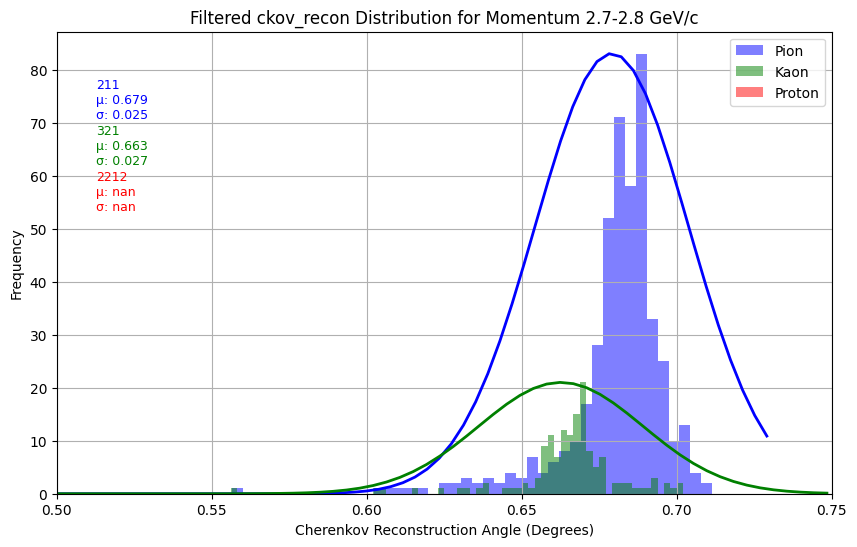

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def specie_histograms_filtered():
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
    ckov_recon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconThisTrack"]

    # Create the mask for ckov_recon positivity and within the momentum range
    ckov_recon_mask = (ckov_recon > 0)
    xMip = all_dicts["ThisTrack;1"]["TrackAttributes_xMipThisTrack"]
    yMip = all_dicts["ThisTrack;1"]["TrackAttributes_yMipThisTrack"]
    xpc = all_dicts["ThisTrack;1"]["TrackAttributes_xPCThisTrack"]
    ypc = all_dicts["ThisTrack;1"]["TrackAttributes_yPCThisTrack"]

    momentum_mask = (momentum > 2.7) & (momentum < 2.8)
    dy = yMip - ypc
    dx = xMip - xpc

    dist = np.sqrt(dx**2 + dy**2)
    dist_mask = dist < 2
    # Set up the histogram plot
    plt.figure(figsize=(10, 6))
    text_y_start = 0.9  # Top of the plot in axes fraction

    # Plot histograms for each species with the combined mask and add Gaussian fit
    for specie_code, color, label in zip([211, 321, 2212], ['blue', 'green', 'red'], ['Pion', 'Kaon', 'Proton']):
        specie_mask = (pdg == specie_code)
        combined_mask = specie_mask & ckov_recon_mask & dist_mask & momentum_mask
        data = ckov_recon[combined_mask]

        # Plot histogram for the filtered data
        count, bins, ignored = plt.hist(data, bins=100, alpha=0.5, color=color, label=label)

        # Fit the Gaussian function to the histogram data
        mu, std = norm.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        p = p * max(count) / max(p)  # scale to match histogram height
        plt.plot(x, p, color=color, linewidth=2)



        # Annotate mean and standard deviation
        plt.text(0.05, text_y_start, f'{specie_code}\nμ: {mu:.3f}\nσ: {std:.3f}', transform=plt.gca().transAxes, color=color, fontsize=9, verticalalignment='top')
        text_y_start -= 0.1  # Move the next annotation down

    plt.title('Filtered ckov_recon Distribution for Momentum 2.7-2.8 GeV/c')
    plt.xlabel('Cherenkov Reconstruction Angle (Degrees)')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xlim(0.5, 0.75)
    plt.grid(True)
    plt.show()

# Call the function to generate the plot
specie_histograms_filtered()


# Prediction by Ckov

## Efficiciency and Purity vs momentum

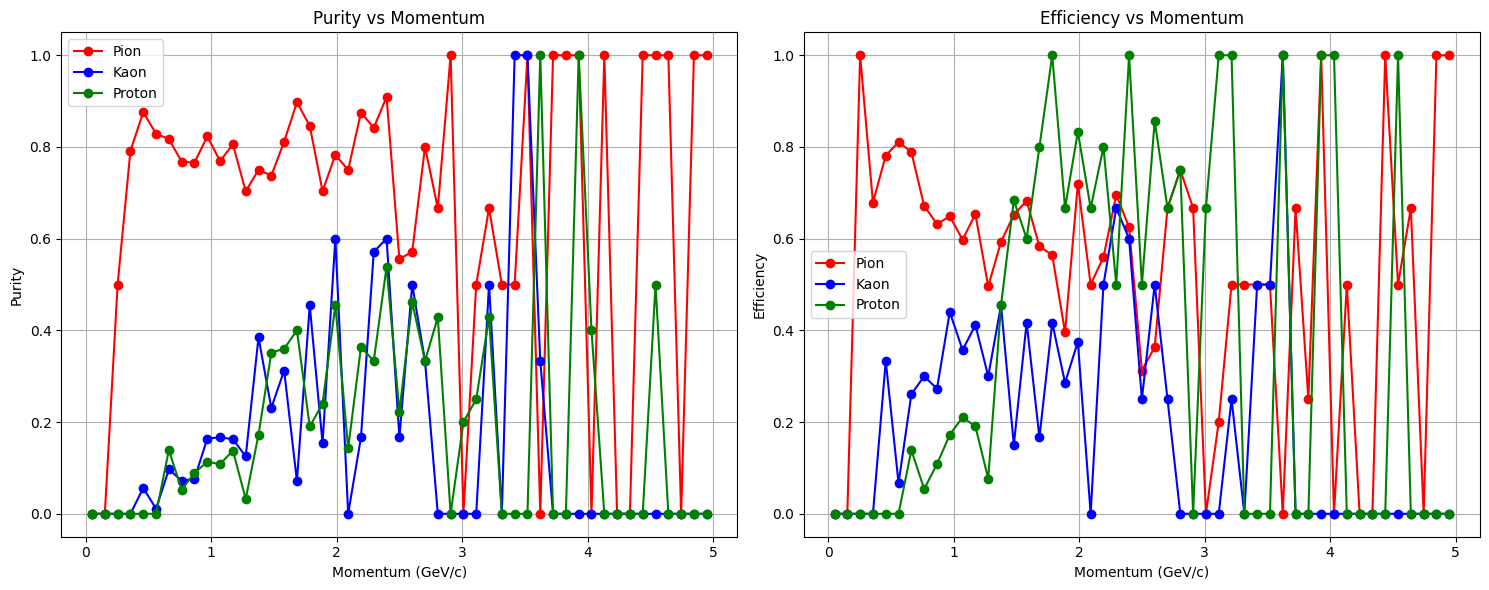

In [ ]:

def calculate_purity_efficiency(all_dicts, momentum_bins):
    # Extract the relevant data from all_dicts
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
    ckov_recon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]

    th_pion = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]
    th_kaon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"]
    th_proton = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"]


    #p_lim = m/(sqrt(n2-1))

    differences = np.abs(np.vstack([ckov_recon - th_pion, ckov_recon - th_kaon, ckov_recon - th_proton]))
    species_indices = np.argmin(differences, axis=0)
    predicted_species = np.select([species_indices == 0, species_indices == 1, species_indices == 2], [211, 321, 2212], default=np.nan)

    species_codes = [211, 321, 2212]  # PDG codes for pions, kaons, protons
    purity = {code: [] for code in species_codes}
    efficiency = {code: [] for code in species_codes}
    momentum_bin_centers = (momentum_bins[1:] + momentum_bins[:-1]) / 2

    # Vectorized binning
    bins = np.digitize(momentum, bins=momentum_bins)

    # Vectorized calculation of true positives, false positives, and total true for each species
    for code in species_codes:
        # Convert boolean arrays to integers for use as weights in np.histogram
        true_positive_weights = (predicted_species[pdg == code] == code).astype(int)
        total_predicted_weights = (predicted_species == code).astype(int)

        true_positives, _ = np.histogram(momentum[pdg == code], bins=momentum_bins, weights=true_positive_weights)
        total_predicted, _ = np.histogram(momentum, bins=momentum_bins, weights=total_predicted_weights)
        total_true, _ = np.histogram(momentum[pdg == code], bins=momentum_bins)

        bin_purity = np.divide(true_positives, total_predicted, out=np.zeros_like(true_positives, dtype=float), where=total_predicted!=0)
        bin_efficiency = np.divide(true_positives, total_true, out=np.zeros_like(true_positives, dtype=float), where=total_true!=0)

        purity[code] = bin_purity
        efficiency[code] = bin_efficiency

    return momentum_bin_centers, purity, efficiency

momentum_bins = np.linspace(0, 5, 50)  # Adjust bins here

momentum_bin_centers, purity, efficiency = calculate_purity_efficiency(all_dicts, momentum_bins)

species_labels = {211: 'Pion', 321: 'Kaon', 2212: 'Proton'}
colors = {211: 'red', 321: 'blue', 2212: 'green'}

plt.figure(figsize=(15, 6))

# Purity plot
plt.subplot(1, 2, 1)
for code in species_labels:
    plt.plot(momentum_bin_centers, purity[code], label=species_labels[code], color=colors[code], marker='o')
plt.title('Purity vs Momentum')
plt.xlabel('Momentum (GeV/c)')
plt.ylabel('Purity')
plt.legend()
plt.grid()

# Efficiency plot
plt.subplot(1, 2, 2)
for code in species_labels:
    plt.plot(momentum_bin_centers, efficiency[code], label=species_labels[code], color=colors[code], marker='o')
plt.title('Efficiency vs Momentum')
plt.xlabel('Momentum (GeV/c)')
plt.ylabel('Efficiency')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



## Contamination

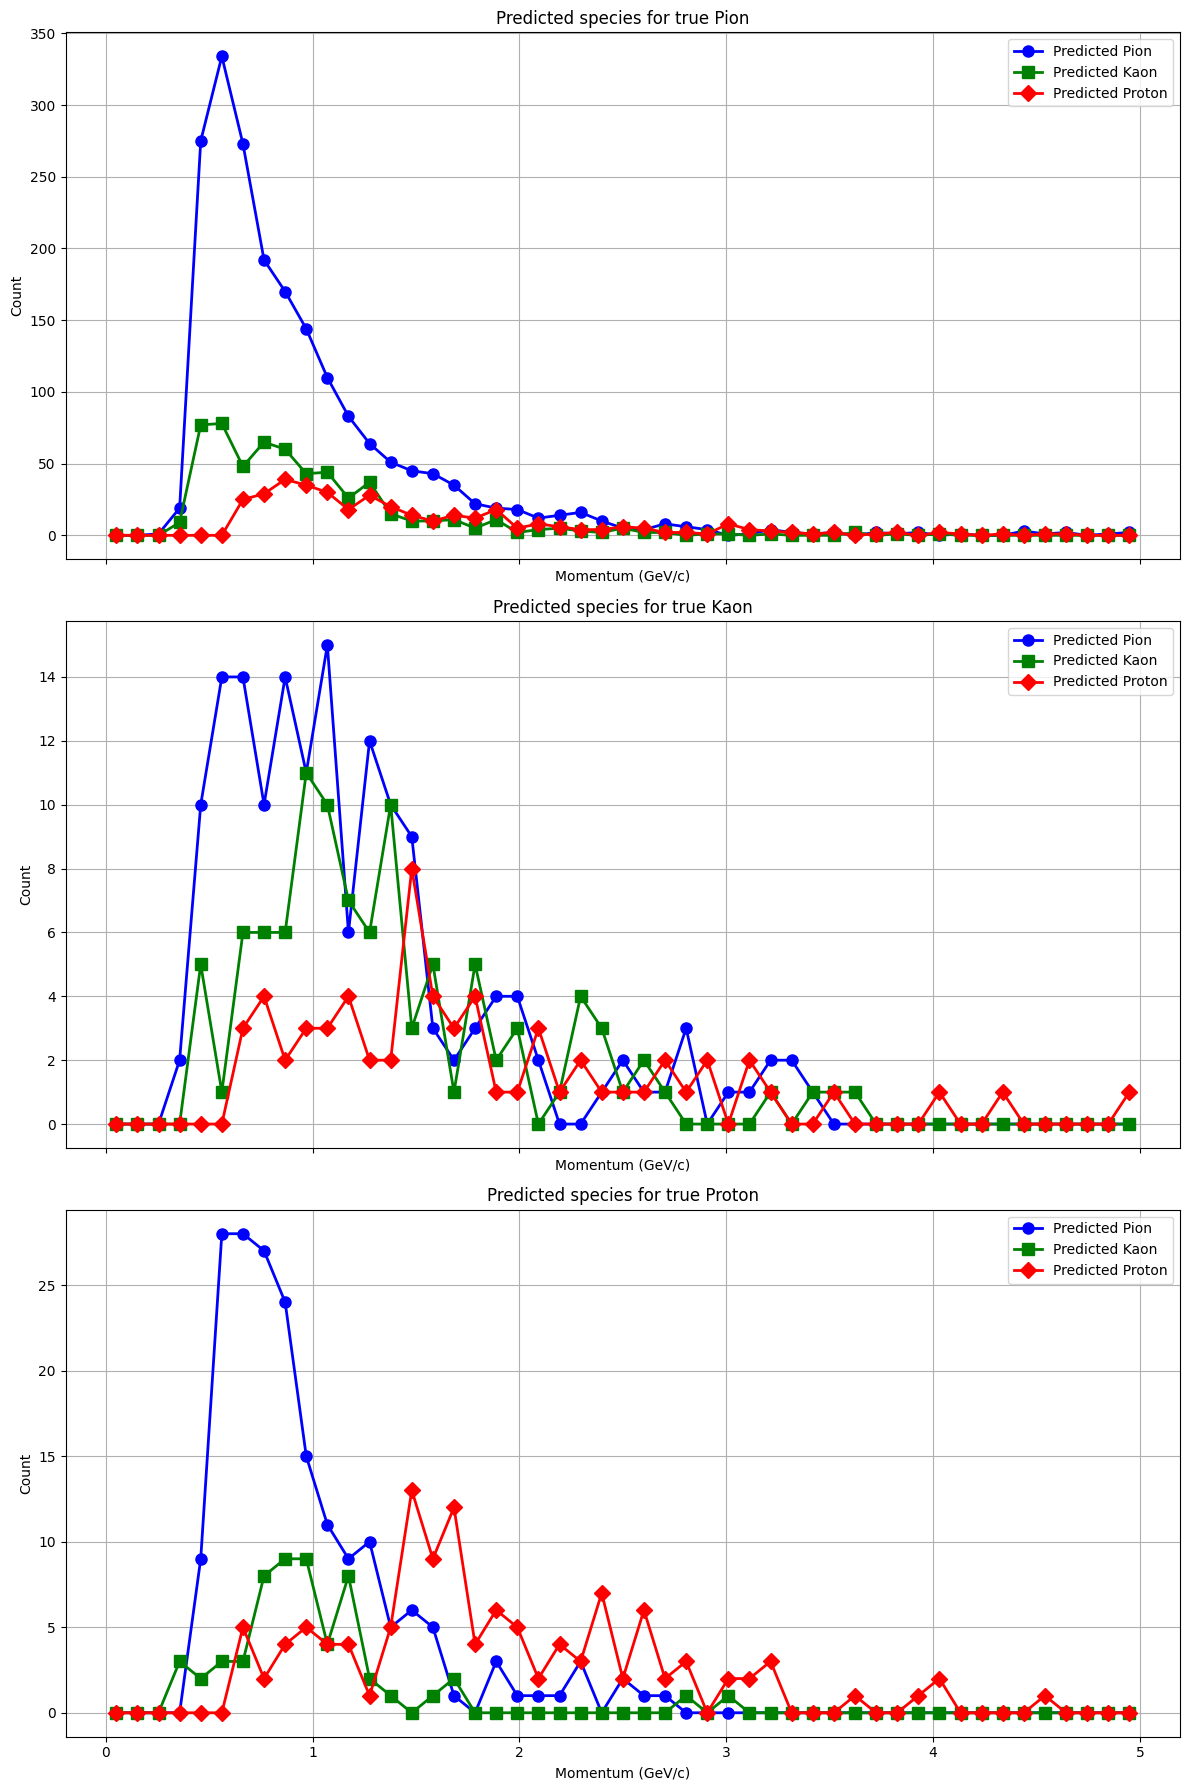

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_contamination(all_dicts, momentum_bins):
    # Extract data
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
    ckov_recon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]

    th_pion = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]
    th_kaon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"]
    th_proton = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"]

    # Determine predicted species using vectorized operations
    differences = np.abs([ckov_recon - th_pion, ckov_recon - th_kaon, ckov_recon - th_proton])
    species_indices = np.argmin(differences, axis=0)
    predicted_species = np.select([species_indices == 0, species_indices == 1, species_indices == 2], [211, 321, 2212])

    contamination = {}
    species_codes = [211, 321, 2212]  # PDG codes for pions, kaons, protons

    # Use numpy's histogramming functions to compute the counts for each predicted species within the true species bins
    for true_species in species_codes:
        contamination_for_true = {}
        true_mask = pdg == true_species
        for pred_species in species_codes:
            predicted_mask = predicted_species == pred_species
            hist, _ = np.histogram(momentum[true_mask & (predicted_species == pred_species)], bins=momentum_bins)
            contamination_for_true[pred_species] = hist
        contamination[true_species] = contamination_for_true

    return contamination

def plot_contamination(contamination, momentum_bin_centers):
    species_labels = {211: 'Pion', 321: 'Kaon', 2212: 'Proton'}
    colors = {211: 'blue', 321: 'green', 2212: 'red'}
    markers = {211: 'o', 321: 's', 2212: 'D'}  # Different marker for each species

    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    # Plotting the contamination for each true species
    for idx, true_species in enumerate([211, 321, 2212]):
        ax = axes[idx]
        ax.set_title(f'Predicted species for true {species_labels[true_species]}')
        ax.set_xlabel('Momentum (GeV/c)')
        ax.set_ylabel('Count')

        for pred_species in [211, 321, 2212]:
            ax.plot(momentum_bin_centers, contamination[true_species][pred_species],
                    label=f'Predicted {species_labels[pred_species]}',
                    color=colors[pred_species], marker=markers[pred_species], linestyle='-', linewidth=2, markersize=8)

        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

momentum_bins = np.linspace(0, 5, 50)  # Adjust the bins here
momentum_bin_centers = (momentum_bins[:-1] + momentum_bins[1:]) / 2

contamination = calculate_contamination(all_dicts, momentum_bins)

# Plot the contamination using the data obtained from the calculation
plot_contamination(contamination, momentum_bin_centers)


# TODO: remove those under Ckov threshold


### Normalised

ckov_recon shape (3871,)
differences shape (3, 3871)


<ipython-input-266-c568822502d1>:72: RuntimeWarning: invalid value encountered in divide
  normalized_counts = contamination[true_species][pred_species] / total_counts


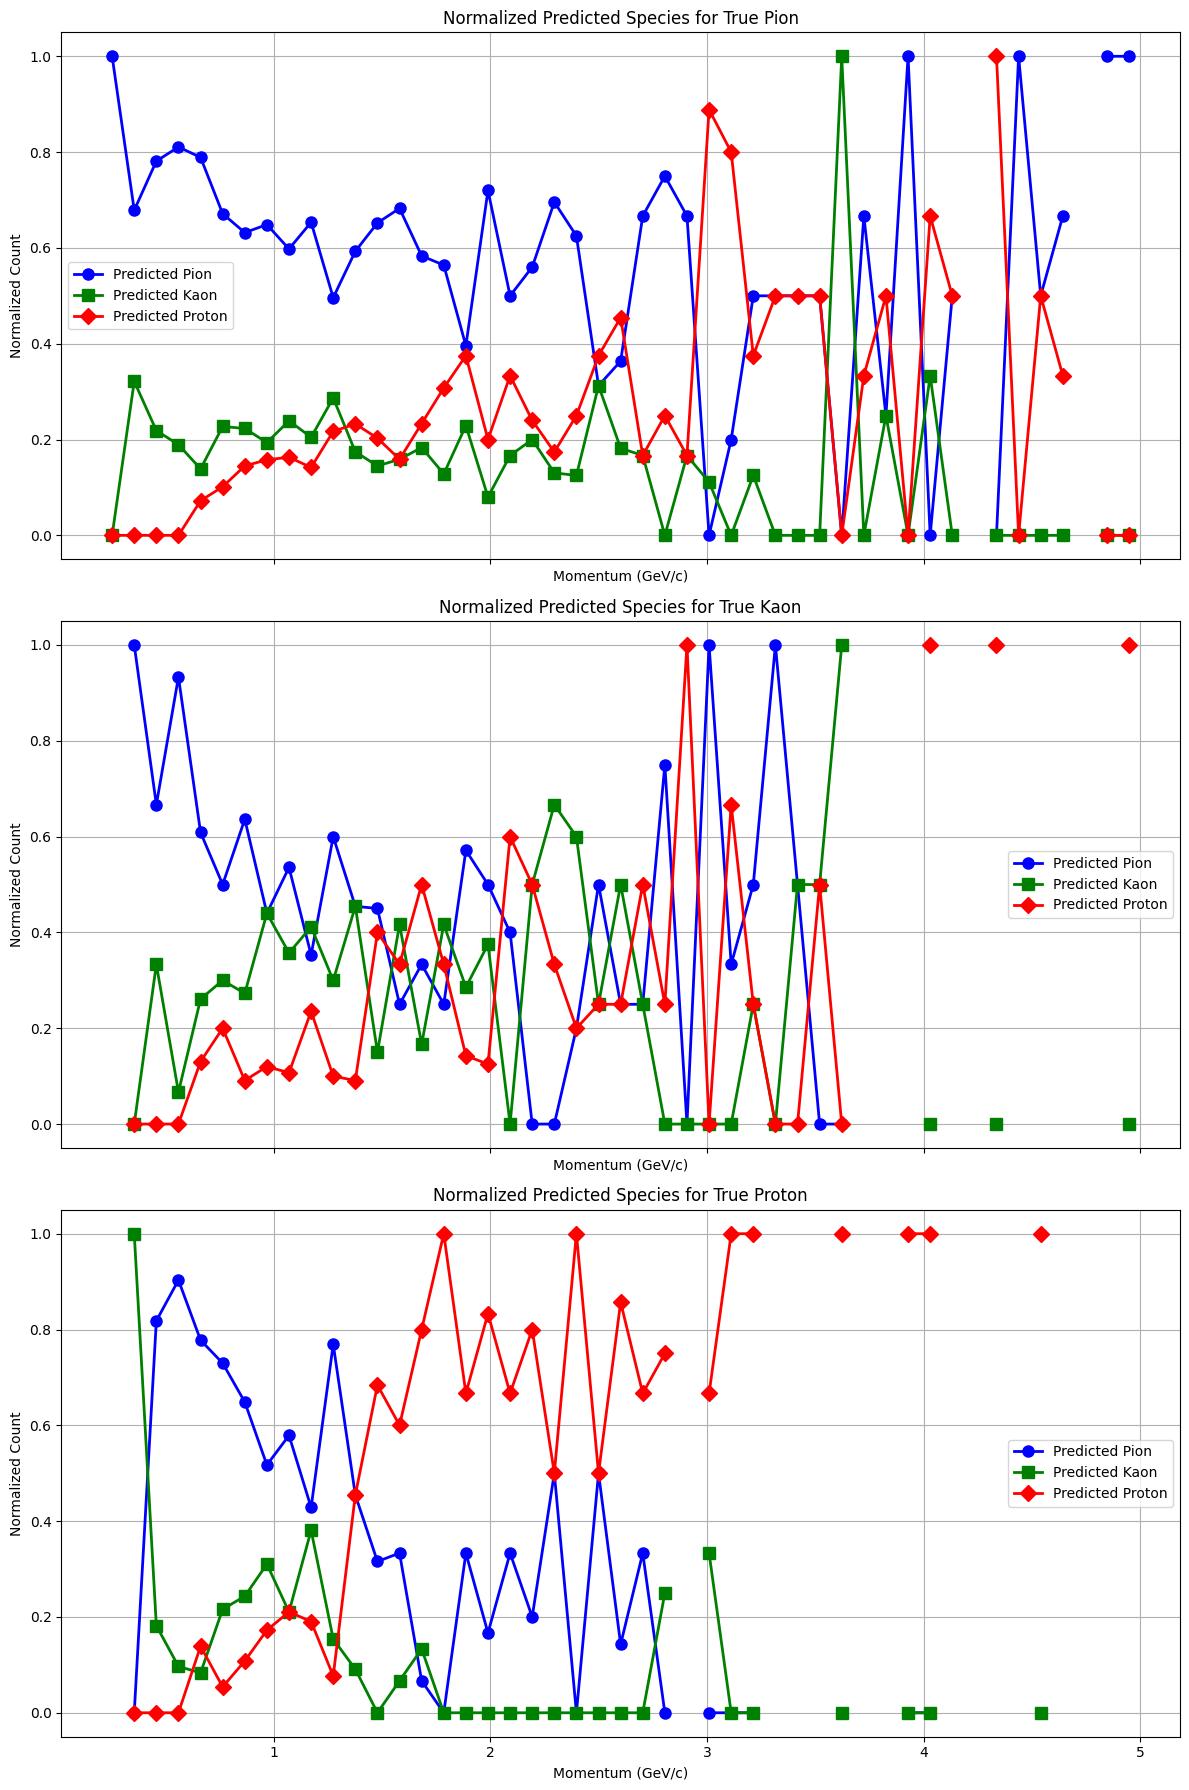

In [ ]:

def calculate_contamination(all_dicts, momentum_bins):
    # Extract data
    pdg = np.abs(all_dicts["McTruth;1"]["mcTruth_pdgCodeTrack;"])
    momentum = all_dicts["ThisTrack;1"]["TrackAttributes_momentumThisTrack"]
    ckov_recon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovReconMassHypThisTrack"]

    th_pion = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThPionThisTrack"]
    th_kaon = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThKaonThisTrack"]
    th_proton = all_dicts["ThisTrack;1"]["TrackAttributes_ckovThProtonThisTrack"]


    # TODO: remove those that are under threshold
    thresh_ckovs = [th_pion>0, th_pion>0, th_pion>0]

    differences = np.abs([ckov_recon - th_pion, ckov_recon - th_kaon, ckov_recon - th_proton])


    thresh_ckovs = [th_pion>0, th_pion>0, th_pion>0]

    print(f"ckov_recon shape {ckov_recon.shape}")
    print(f"differences shape {differences.shape}")
    #ckov_recon shape (3871,)
    #differences shape (3, 3871)

    #differences_masked_for_thresh = differences[zip]

    species_indices = np.argmin(differences, axis=0)
    predicted_species = np.select([species_indices == 0, species_indices == 1, species_indices == 2], [211, 321, 2212])

    contamination = {}
    totals = {}
    species_codes = [211, 321, 2212]  # PDG codes for pions, kaons, protons

    # p_lim = m/(sqrt(n**2-1))

    p_lims = (0.4, 0.8, 1.2)
    # Compute the counts for each predicted species within the true species bins
    for true_species, thresh_ckov, p_lim in zip(species_codes, thresh_ckovs, p_lims):
        true_mask = (pdg == true_species) & (thresh_ckov)


        total_hist, _ = np.histogram(momentum[true_mask], bins=momentum_bins)  # Total counts for normalization
        totals[true_species] = total_hist
        contamination_for_true = {}

        for pred_species, thresh_ckov in zip(species_codes, thresh_ckovs):
            predicted_mask = (predicted_species == pred_species)
            hist, _ = np.histogram(momentum[true_mask & (predicted_species == pred_species)], bins=momentum_bins)
            contamination_for_true[pred_species] = hist

        contamination[true_species] = contamination_for_true

    return contamination, totals

def plot_contamination(contamination, totals, momentum_bin_centers):
    species_labels = {211: 'Pion', 321: 'Kaon', 2212: 'Proton'}
    colors = {211: 'blue', 321: 'green', 2212: 'red'}
    markers = {211: 'o', 321: 's', 2212: 'D'}  # Different marker for each species

    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    # Plotting the normalized contamination for each true species
    for idx, true_species in enumerate([211, 321, 2212]):
        ax = axes[idx]
        ax.set_title(f'Normalized Predicted Species for True {species_labels[true_species]}')
        ax.set_xlabel('Momentum (GeV/c)')
        ax.set_ylabel('Normalized Count')

        total_counts = totals[true_species]

        for pred_species in [211, 321, 2212]:
            normalized_counts = contamination[true_species][pred_species] / total_counts
            ax.plot(momentum_bin_centers, normalized_counts,
                    label=f'Predicted {species_labels[pred_species]}',
                    color=colors[pred_species], marker=markers[pred_species], linestyle='-', linewidth=2, markersize=8)

        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run the modified functions
contamination, totals = calculate_contamination(all_dicts, momentum_bins)
plot_contamination(contamination, totals, momentum_bin_centers)


## Confusion matrix

In [ ]:
import numpy as np
def assign_labels2(ckov_recon, ckov_theoretical):
    labels = np.full(ckov_recon.shape[0], -1, dtype=int)  # Initialize labels array with -1
    threshold = np.arccos(1 / (1.2904 + 0.056 * 3))  # Calculate threshold

    for i in range(ckov_recon.shape[0]):
        recon_value = ckov_recon[i, 0]  # Extract the ckov recon value

        # Check for special conditions first
        if recon_value <= 0 or recon_value > threshold:
            continue  # Leave the label as -1 and move on

        # Calculate the absolute differences with theoretical values
        differences = np.abs(ckov_theoretical[i, :] - recon_value)

        # Find the index (label) of the smallest difference
        labels[i] = np.argmin(differences)

    return labels

def assign_labels(ckov_recon, ckov_theoretical):
    labels = np.zeros(ckov_recon.shape[0], dtype=int)  # Initialize labels array
    threshold = np.arccos(1 / (1.2904 + 0.0056 * 3))  # Calculate threshold

    for i in range(ckov_recon.shape[0]):
        recon_value = ckov_recon[i, 0]  # Extract the ckov recon value

        # Check for special conditions first
        if recon_value <= 0 or recon_value > threshold:
            labels[i] = 3
            continue

        # Calculate the absolute differences with theoretical values
        differences = np.abs(ckov_theoretical[i, :] - recon_value)

        # Find the index (label) of the smallest difference
        labels[i] = np.argmin(differences)

    return labels
import numpy as np

def one_hot_encode_labels(labels, num_classes=3):
    # Initialize the one-hot encoded matrix
    one_hot_encoded = np.zeros((labels.shape[0], num_classes))

    for i, label in enumerate(labels):
        if label in [0, 1, 2]:  # Check if the label is 0, 1, or 2
            one_hot_encoded[i, label] = 1

    return one_hot_encoded

def compare_with_true(y_true, labels_encoded):
    correct_predictions = np.sum(np.all(y_true == labels_encoded, axis=1))
    total = labels_encoded.shape[0]

    accuracy = correct_predictions / total
    return accuracy, correct_predictions

# Assign labels based on the closest theoretical value or special condition
labels = assign_labels(train_ckov_recon, train_ckov_theoretical)

# One-hot encode the assigned labels
labels_encoded = one_hot_encode_labels(labels)

# Compare the one-hot encoded labels with the true labels
accuracy, correct_predictions = compare_with_true(y_train_true, labels_encoded)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Correct Predictions: {correct_predictions} out of {y_train_true.shape[0]}")


# labels[labels==3]


# train_ckov_recon[labels==3]
# # print(train_ckov_recon[train_ckov_recon>1])
# # train_ckov_recon[train_ckov_recon<0]

#cm = create_confusion_matrix(y_train_true, labels)

# fig, axs = plt.subplots(1, 4, figsize=(25, 6))

# y_pred_train_labels = np.argmax(y_pred_train, axis=1)
# y_pred_test_labels = np.argmax(y_pred_test, axis=1)


# y_train_trueL = np.argmax(y_train_true, axis=1)
# y_test_trueL = np.argmax(y_test_true, axis=1)

# # Confusion Matrix for train data
# cm_train = confusion_matrix(y_train_trueL, y_pred_train_labels)
# plot_confusion_matrix(axs[2], cm_train, title="Train Confusion Matrix")

NameError: name 'train_ckov_recon' is not defined

In [ ]:
# Define the plotting function for the confusion matrix with an extra 'Rejected' category
def plot_confusion_matrix_htm(ax, cm, labels, title="Confusion Matrix"):
    """Utility function to plot the confusion matrix."""
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd' if cm.dtype.kind == 'i' else '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def plot_confusion_matrix_htm3(ax, cm, labels, title="Confusion Matrix"):
    """Utility function to plot the confusion matrix with percentages."""
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percent = (cm[i, j] / np.sum(cm[i])) * 100 if np.sum(cm[i]) > 0 else 0
            text = f"{cm[i, j]}\n({percent:.1f}%)"
            thresh = cm.max() / 2.
            ax.text(j, i, text, ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

def plot_confusion_matrix_htm2(ax, cm, title="Confusion Matrix"):
    """Utility function to plot the confusion matrix."""
    ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['Pion', 'Kaon', 'Proton'], fontsize=13)
    ax.set_yticklabels(['Pion', 'Kaon', 'Proton'], fontsize=13)
    ax.set_title(title, fontsize=LARGE_FONT_SIZE * 1.25)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percent = (cm[i, j] / np.sum(cm[i])) * 100 if np.sum(cm[i]) > 0 else 0
            text = f"{cm[i, j]}\n({percent:.1f}%)"
            thresh = cm.max() / 2.
            ax.text(j, i, text, ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Assign labels based on the closest theoretical value or special condition
labels = assign_labels(train_ckov_recon, train_ckov_theoretical)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
train_mask = (train_ckov_recon >= 0).reshape(-1)
test_mask = (test_ckov_recon >= 0).reshape(-1)

# Step 1: Assign labels for both training and testing data
print(train_ckov_recon.shape)
print(train_ckov_theoretical.shape)

train_ckov_recon_filt = train_ckov_recon[train_mask]
train_ckov_theoretical_filt = train_ckov_theoretical[train_mask]

test_ckov_recon_filt = test_ckov_recon[test_mask]
test_ckov_theoretical_filt = test_ckov_theoretical[test_mask]

print(f" test_ckov_recon_filt shape {test_ckov_recon_filt.shape}")
print(f" test_ckov_theoretical_filt shape {test_ckov_theoretical_filt.shape}")


train_labels = assign_labels(train_ckov_recon_filt, train_ckov_theoretical_filt)
test_labels = assign_labels(test_ckov_recon_filt, test_ckov_theoretical_filt)


y_train_true_filt =  y_train_true[train_mask]
y_test_true_filt = y_test_true[test_mask]



# Step 2: Convert y_train_true and y_test_true from one-hot encoded to class labels
y_train_true_labels = np.argmax(y_train_true_filt, axis=1)
y_test_true_labels = np.argmax(y_test_true_filt, axis=1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(25, 6))


print(f" y_train_true_filt shape {y_train_true_filt.shape}")
print(f" y_test_true_filt shape {y_test_true_filt.shape}")
print(f" y_train_true shape {y_train_true.shape}")
print(f" y_test_true shape {y_test_true.shape}")
print(f" y_train_true_labels shape {y_train_true_labels.shape}")
print(f" y_test_true_labels shape {y_test_true_labels.shape}")


valid_train_indices = ~np.isnan(train_labels)
valid_test_indices = ~np.isnan(test_labels)
categories = ['Pion', 'Kaon', 'Proton']  # Add 'Rejected' as the fourth category

# Confusion Matrix for training data
cm_train = confusion_matrix(y_train_true_labels[valid_train_indices], train_labels[valid_train_indices], labels=[0, 1, 2])

plot_confusion_matrix_htm3(axs[0], cm_train, categories, title="Train Confusion Matrix for HTM")

# Confusion Matrix for testing data


cm_test = confusion_matrix(y_test_true_labels[valid_test_indices], test_labels[valid_test_indices], labels=[0, 1, 2])
plot_confusion_matrix_htm3(axs[1], cm_test, categories, title="Test Confusion Matrix for HTM")

plt.tight_layout()
plt.show()
